In [1]:
import os
import pickle
import joblib
import re
import string
import subprocess
import random
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta


import lightgbm
from xgboost import XGBClassifier
from multiprocessing import cpu_count
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, roc_curve

from hocelot.dlutils import get_col_feats, read_raw_data
from hocelot.dlutils import open as open_dlutils # open for saving PKL
#from hocelot.dlutils.miscellaneous import RANDOM_SEED, hocelot_colors
from hocelot.rdt import RDTransformer
from hocelot.dlmodels import XGBClassifierSelector
from hocelot.dlplots import ModelResultsGrapher, ModelExplainabilityGrapher, DefaultGrapher
#from hocelot.dlplots.classification.general_plots import plot_target_stability
from hocelot.dlmetadata import HOCELOT_DTYPES, HOCELOT_FTYPES, LOG_TRANSFORMABLE_1

from hocelot.dlutils import open

plt.style.use('ggplot')
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)
pd.set_option('display.max_rows', 100)

HOCELOT_YELLOW = '#FDD226'
HOCELOT_BLACK = '#000000'
HOCELOT_RED = '#FF5753'
HOCELOT_BLUE = '#2B3252'
HOCELOT_WHITE = '#FFFFFF'

%matplotlib inline
warnings.filterwarnings('ignore')
import ast

# CARGAR FICHEROS

In [2]:
df_muestra = pd.read_csv('gs://hocelot_mx_analytics/colombia/input/170-00002_Telefonica/Telefonica_CO_envio_10_04_2023.csv',   sep=';', index_col=False)
print(df_muestra.shape)
df_muestra.head()

(18235, 37)


,NOMBRE_CLIENTE,FECHA_NACIMIENTO,EDAD_GRUPO,NUM_IDENT,DIRECCION,DIRECCION_FACT,CIUDAD,REGION,CODIGO_POSTAL,EMAIL,EMAIL_FS,TELEFONO,CUENTA_FS,OPERACION,TENENCIA,TIPO_PRODUCTO,CANAL_ALTA,TARIFA,FECHA_ALTA,FECHA_BAJA,ESTADO_CLIENTE,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMP_CONSUMO,IMP_TERMINAL,PLAZOS_FINANCIACION,PLAZOS_FALTANTES,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO,ESTADO_CIVIL,RIESGO_ORIGINACION,RIESGO_MANTENIMIENTO,CARTERA_ACT
0,LINA YISELT ESCOBEDO VALENCIA,NaN,29-35,1.115067e+09,KR KR 16 CL 30 50,NaN,GUADALAJARA DE BUGA,SUROCCIDENTE,NaN,notienecorreo@gmail.com,linayiselt2004@gmail.com,NaN,6018966618,MOVIL,NaN,NaN,NaN,NaN,2020-08-10,2100-01-01,NaN,BEC0169773247,2021-07-14,2021-07-23,33988,33988,0,NaN,NaN,NO,0.0,33988,2021-07-23,NaN,MA,Alto_Riesgo,NaN
1,LINA YISELT ESCOBEDO VALENCIA,NaN,29-35,1.115067e+09,KR KR 16 CL 30 50,NaN,GUADALAJARA DE BUGA,SUROCCIDENTE,NaN,notienecorreo@gmail.com,linayiselt2004@gmail.com,NaN,6018966618,MOVIL,NaN,NaN,NaN,NaN,2020-08-10,2100-01-01,NaN,BEC0218361857,2022-04-11,2022-04-21,35102,35102,0,NaN,NaN,NO,NaN,35102,2022-04-23,NaN,MA,Alto_Riesgo,NaN
2,ORNEY JOSE PUELLO ESPAÑA,NaN,29-35,7.233723e+07,CLL 7C #11 100,NaN,BOGOTA DC,NaN,NaN,acuaries1625@gmail.com,acuaries1625@gmail.com,NaN,6018992488,MOVIL,NaN,NaN,NaN,NaN,2020-08-10,2100-01-01,NaN,BEC0170127389,2021-07-17,2021-07-24,137027,87031,49996,12.0,8.0,NO,0.0,137027,2021-07-30,NaN,NaN,Alto_Riesgo,NaN
3,CRISTOBAL BARRIOS PITALUA,NaN,56-65,9.088206e+06,CL 35 KR 49-19,NaN,CARTAGENA,COSTA,NaN,karinabarrios80@outlook.es,karinabarrios80@outlook.es,NaN,6020445478,FIJO,LB+BA,NaN,NaN,NaN,2020-09-21,2100-01-01,NaN,BEC0173888702,2021-08-04,2021-08-13,56713,56713,0,NaN,NaN,SI,19594.0,0,NaN,NaN,NaN,Medio_Riesgo,19594.0
4,OSMELIA RANGEL PEREZ,NaN,29-35,1.063488e+09,MZ S CASA 9 ARKALA II,NaN,IBAGUE,ORIENTE,NaN,osmeliarangelperez@gmail.com,osmeliarangelperez@gmail.com,NaN,6021025942,FIJO,LB+BA,NaN,NaN,NaN,2020-10-07,2100-01-01,NaN,BEC0219153140,2022-04-19,2022-04-26,1393,1393,0,NaN,NaN,SI,1393.0,0,NaN,NaN,NaN,Alto_Riesgo,1393.0


## 0.1: Transformación de formatos

In [3]:
df_muestra.dtypes

NOMBRE_CLIENTE           object
FECHA_NACIMIENTO        float64
EDAD_GRUPO               object
NUM_IDENT               float64
DIRECCION                object
DIRECCION_FACT          float64
CIUDAD                   object
REGION                   object
CODIGO_POSTAL           float64
EMAIL                    object
EMAIL_FS                 object
TELEFONO                float64
CUENTA_FS                 int64
OPERACION                object
TENENCIA                 object
TIPO_PRODUCTO            object
CANAL_ALTA              float64
TARIFA                  float64
FECHA_ALTA               object
FECHA_BAJA               object
ESTADO_CLIENTE           object
NUM_FACTURA              object
FEC_EMISION              object
FEC_VENCIMIENTO          object
IMP_FACTURADO             int64
IMP_CONSUMO               int64
IMP_TERMINAL              int64
PLAZOS_FINANCIACION     float64
PLAZOS_FALTANTES        float64
IMPAGADO                 object
IMPORTE_IMPAGADO        float64
IMPORTE_

## 0.2: Eliminacion de los ultimos 4 meses

In [4]:
df_muestra['FEC_EMISION'].min()

'2021-01-04'

In [5]:
df_muestra['FEC_VENCIMIENTO'].max()

'2022-12-28'

In [6]:
df_muestra = df_muestra[df_muestra['FEC_VENCIMIENTO']<'2022-08-31']

## 0.3 Recalculo de importes impagado y recuperados

Los importes recuperados e impagados no significan lo que deseamos. 
El importe impagado indica el importe pendiente
El importe recuperado indica cuanto se ha pagado

In [8]:
df_muestra['IMPAGADO'] = np.where((df_muestra['FEC_VENCIMIENTO']<df_muestra['FECHA_RECUPERADO'])&(df_muestra['FECHA_RECUPERADO'].notnull()),'SI','NO')

In [9]:
df_muestra['IMPORTE_IMPAGADO'] = np.where(df_muestra['IMPAGADO']=='SI',df_muestra['IMP_FACTURADO'],0)

In [10]:
df_muestra['IMPORTE_RECUPERADO'] = np.where(df_muestra['IMPAGADO']=='SI',df_muestra['IMPORTE_RECUPERADO'],0)

In [11]:
df_muestra['FECHA_RECUPERADO'] = np.where(df_muestra['IMPAGADO']=='SI',df_muestra['FECHA_RECUPERADO'],np.nan)

# PASO 1: REVISAR CAMPOS

In [7]:
df_muestra.head()

,NOMBRE_CLIENTE,FECHA_NACIMIENTO,EDAD_GRUPO,NUM_IDENT,DIRECCION,DIRECCION_FACT,CIUDAD,REGION,CODIGO_POSTAL,EMAIL,EMAIL_FS,TELEFONO,CUENTA_FS,OPERACION,TENENCIA,TIPO_PRODUCTO,CANAL_ALTA,TARIFA,FECHA_ALTA,FECHA_BAJA,ESTADO_CLIENTE,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMP_CONSUMO,IMP_TERMINAL,PLAZOS_FINANCIACION,PLAZOS_FALTANTES,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO,ESTADO_CIVIL,RIESGO_ORIGINACION,RIESGO_MANTENIMIENTO,CARTERA_ACT
0,LINA YISELT ESCOBEDO VALENCIA,NaN,29-35,1.115067e+09,KR KR 16 CL 30 50,NaN,GUADALAJARA DE BUGA,SUROCCIDENTE,NaN,notienecorreo@gmail.com,linayiselt2004@gmail.com,NaN,6018966618,MOVIL,NaN,NaN,NaN,NaN,2020-08-10,2100-01-01,NaN,BEC0169773247,2021-07-14,2021-07-23,33988,33988,0,NaN,NaN,NO,0.0,33988,2021-07-23,NaN,MA,Alto_Riesgo,NaN
1,LINA YISELT ESCOBEDO VALENCIA,NaN,29-35,1.115067e+09,KR KR 16 CL 30 50,NaN,GUADALAJARA DE BUGA,SUROCCIDENTE,NaN,notienecorreo@gmail.com,linayiselt2004@gmail.com,NaN,6018966618,MOVIL,NaN,NaN,NaN,NaN,2020-08-10,2100-01-01,NaN,BEC0218361857,2022-04-11,2022-04-21,35102,35102,0,NaN,NaN,NO,NaN,35102,2022-04-23,NaN,MA,Alto_Riesgo,NaN
2,ORNEY JOSE PUELLO ESPAÑA,NaN,29-35,7.233723e+07,CLL 7C #11 100,NaN,BOGOTA DC,NaN,NaN,acuaries1625@gmail.com,acuaries1625@gmail.com,NaN,6018992488,MOVIL,NaN,NaN,NaN,NaN,2020-08-10,2100-01-01,NaN,BEC0170127389,2021-07-17,2021-07-24,137027,87031,49996,12.0,8.0,NO,0.0,137027,2021-07-30,NaN,NaN,Alto_Riesgo,NaN
3,CRISTOBAL BARRIOS PITALUA,NaN,56-65,9.088206e+06,CL 35 KR 49-19,NaN,CARTAGENA,COSTA,NaN,karinabarrios80@outlook.es,karinabarrios80@outlook.es,NaN,6020445478,FIJO,LB+BA,NaN,NaN,NaN,2020-09-21,2100-01-01,NaN,BEC0173888702,2021-08-04,2021-08-13,56713,56713,0,NaN,NaN,SI,19594.0,0,NaN,NaN,NaN,Medio_Riesgo,19594.0
4,OSMELIA RANGEL PEREZ,NaN,29-35,1.063488e+09,MZ S CASA 9 ARKALA II,NaN,IBAGUE,ORIENTE,NaN,osmeliarangelperez@gmail.com,osmeliarangelperez@gmail.com,NaN,6021025942,FIJO,LB+BA,NaN,NaN,NaN,2020-10-07,2100-01-01,NaN,BEC0219153140,2022-04-19,2022-04-26,1393,1393,0,NaN,NaN,SI,1393.0,0,NaN,NaN,NaN,Alto_Riesgo,1393.0


In [9]:
38640.0+37342

75982.0

In [8]:
df_muestra[(df_muestra['IMPORTE_IMPAGADO']>0)&(df_muestra['IMPORTE_RECUPERADO']>0)]

,NOMBRE_CLIENTE,FECHA_NACIMIENTO,EDAD_GRUPO,NUM_IDENT,DIRECCION,DIRECCION_FACT,CIUDAD,REGION,CODIGO_POSTAL,EMAIL,EMAIL_FS,TELEFONO,CUENTA_FS,OPERACION,TENENCIA,TIPO_PRODUCTO,CANAL_ALTA,TARIFA,FECHA_ALTA,FECHA_BAJA,ESTADO_CLIENTE,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMP_CONSUMO,IMP_TERMINAL,PLAZOS_FINANCIACION,PLAZOS_FALTANTES,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO,ESTADO_CIVIL,RIESGO_ORIGINACION,RIESGO_MANTENIMIENTO,CARTERA_ACT
1306,EMELY DEL ROSARIO NARVAEZ,NaN,22-28,1.143398e+09,CALLE 33 NO. 26 - 49,NaN,CARTAGENA,NaN,NaN,no.tiene@gmail.com,gipanape05@hotmail.com,3.158902e+09,6017357779,MOVIL,NaN,NaN,NaN,NaN,2020-06-12,2100-01-01,Desactivada,BEC0159242830,2021-05-12,2021-05-22,77485,33988,43497,18.0,7.0,SI,38640.0,37342,2021-06-11,NaN,BR,Alto_Riesgo,38640.0
8341,ROSA LINDA GARCIA MONCADA,NaN,22-28,1.116801e+09,KR 26 # 16-36 - GUADATARO,NaN,ARAUCA,ORIENTE,NaN,rgarciaindurama@gmail.com,linda_13de1995@hotmail.com,3.158145e+09,1040510270,MOVIL,NaN,Min y sms ilimitados a todo destino nal + Ilim...,NaN,NaN,2017-08-10,2099-12-31,Suspension-parcial,BEC0175435486,2021-08-16,2021-08-24,42553,4056,38497,18.0,5.0,SI,38497.0,317,2021-08-30,NaN,NaN,Medio_Riesgo,38497.0
8390,ROSA LINDA GARCIA MONCADA,NaN,22-28,1.116801e+09,KR 26 # 16-36 - GUADATARO,NaN,ARAUCA,ORIENTE,NaN,rgarciaindurama@gmail.com,linda_13de1995@hotmail.com,3.158145e+09,1040510270,MOVIL,NaN,Min y sms ilimitados a todo destino nal + Ilim...,NaN,NaN,2017-08-10,2099-12-31,Suspension-parcial,BEC0170191940,2021-07-17,2021-07-24,41837,3340,38497,18.0,6.0,SI,35339.0,6408,2022-06-30,NaN,NaN,Medio_Riesgo,35339.0
8394,ROSA LINDA GARCIA MONCADA,NaN,22-28,1.116801e+09,KR 26 # 16-36 - GUADATARO,NaN,ARAUCA,ORIENTE,NaN,rgarciaindurama@gmail.com,linda_13de1995@hotmail.com,3.158145e+09,1040510270,MOVIL,NaN,Min y sms ilimitados a todo destino nal + Ilim...,NaN,NaN,2017-08-10,2099-12-31,Suspension-parcial,BEC0180676458,2021-09-15,2021-09-24,133094,94597,38497,18.0,4.0,SI,38497.0,55597,2021-12-07,NaN,NaN,Medio_Riesgo,38497.0
11557,RUTILIO MUOZ,NaN,46-55,9.832255e+07,CRA 3 MZ C CASA 58 BARRIO LOS JARDINES,NaN,SAN PABLO,SUROCCIDENTE,NaN,no@no.com,NaN,3.185904e+09,6002481879,MOVIL,NaN,Tu plan tiene Minutos y SMS a todo destino nac...,NaN,NaN,2018-11-05,2100-01-01,Suspension-parcial,BEC0234696351,2022-07-07,2022-07-15,110054,43563,66491,12.0,4.0,SI,63794.0,40866,2022-12-05,NaN,NaN,Alto_Riesgo,63794.0
14646,CESAR ARMANDO CASTRO DIAZ,NaN,29-35,1.045682e+09,KR 27 C CL 17 35,NaN,BARRANQUILLA,COSTA,NaN,czarkztro@gmail.com,czarkztro@gmail.com,3.205563e+09,6019865810,MOVIL,NaN,Tu plan tiene Minutos y SMS a todo destino nac...,NaN,NaN,2020-08-31,2100-01-01,Pre-desactivada,BEC0185556608,2021-10-12,2021-10-22,71238,35295,35943,18.0,17.0,SI,35943.0,27295,2022-01-06,NaN,BM,Medio_Riesgo,35943.0
15434,SAUL ANTONIO MARQUEZ TORRES,NaN,36-45,9.761247e+07,OT VEREDA CRISTALINAS-,NaN,PEREIRA,NOROCCIDENTE,NaN,saul@hotmail.com,saul@hotmail.com,3.168199e+09,6019837446,MOVIL,NaN,Tu plan tiene Minutos y SMS a todo destino nac...,NaN,NaN,2020-08-28,2100-01-01,Activa,BEC0163413990,2021-06-06,2021-06-12,90910,30914,59996,12.0,6.0,SI,19992.0,30914,2021-10-06,NaN,NaN,Alto_Riesgo,19992.0
15496,SAUL ANTONIO MARQUEZ TORRES,NaN,36-45,9.761247e+07,OT VEREDA CRISTALINAS-,NaN,PEREIRA,NOROCCIDENTE,NaN,saul@hotmail.com,saul@hotmail.com,3.168199e+09,6019837446,MOVIL,NaN,Tu plan tiene Minutos y SMS a todo destino nac...,NaN,NaN,2020-08-28,2100-01-01,Activa,BEC0194978599,2021-12-04,2021-12-13,96315,36321,59994,12.0,0.0,SI,59994.0,30762,2022-01-17,NaN,NaN,Alto_Riesgo,59994.0


# Paso 2: Missing values y valores incorrectos

In [160]:
get_col_feats(df_muestra)

100%|██████████| 23/23 [00:00<00:00, 488.02it/s]


,dtype,sample,n_missing,perc_missing,n_unique
level_0,int64,0,0,0.0000,15808
index,int64,0,0,0.0000,15808
Id_cli_fact,object,1115066610.0BEC0169773247,0,0.0000,15808
NOMBRE_CLIENTE,object,LINA YISELT ESCOBEDO VALENCIA,8,0.0506,998
EDAD_GRUPO,object,29-35,987,6.2437,8
NUM_IDENT,float64,1115066610.0000,2,0.0127,998
DIRECCION,object,KR KR 16 CL 30 50,82,0.5187,980
CIUDAD,object,GUADALAJARA DE BUGA,25,0.1581,182
REGION,object,SUROCCIDENTE,1093,6.9142,7
TELEFONO,float64,2500388671.0000,4139,26.1829,581


In [14]:
df_muestra.dropna(how='all',inplace=True)
df_muestra.dropna(axis=1,how='all',inplace=True)
print(df_muestra.shape)
df_muestra.head()

(15818, 31)


,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,EMAIL,EMAIL_FS,TELEFONO,CUENTA_FS,OPERACION,TENENCIA,TIPO_PRODUCTO,FECHA_ALTA,FECHA_BAJA,ESTADO_CLIENTE,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMP_CONSUMO,IMP_TERMINAL,PLAZOS_FINANCIACION,PLAZOS_FALTANTES,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO,RIESGO_ORIGINACION,RIESGO_MANTENIMIENTO,CARTERA_ACT
0,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,notienecorreo@gmail.com,linayiselt2004@gmail.com,nan,6018966618,MOVIL,NaN,NaN,2020-08-10,2100-01-01,NaN,BEC0169773247,2021-07-14,2021-07-23,33988,33988,0,nan,nan,NO,0,0,NaN,MA,Alto_Riesgo,nan
1,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,notienecorreo@gmail.com,linayiselt2004@gmail.com,nan,6018966618,MOVIL,NaN,NaN,2020-08-10,2100-01-01,NaN,BEC0218361857,2022-04-11,2022-04-21,35102,35102,0,nan,nan,SI,35102,35102,2022-04-23,MA,Alto_Riesgo,nan
2,ORNEY JOSE PUELLO ESPAÑA,29-35,72337228.0000,CLL 7C #11 100,BOGOTA DC,NaN,acuaries1625@gmail.com,acuaries1625@gmail.com,nan,6018992488,MOVIL,NaN,NaN,2020-08-10,2100-01-01,NaN,BEC0170127389,2021-07-17,2021-07-24,137027,87031,49996,12.0000,8.0000,SI,137027,137027,2021-07-30,NaN,Alto_Riesgo,nan
3,CRISTOBAL BARRIOS PITALUA,56-65,9088206.0000,CL 35 KR 49-19,CARTAGENA,COSTA,karinabarrios80@outlook.es,karinabarrios80@outlook.es,nan,6020445478,FIJO,LB+BA,NaN,2020-09-21,2100-01-01,NaN,BEC0173888702,2021-08-04,2021-08-13,56713,56713,0,nan,nan,NO,0,0,NaN,NaN,Medio_Riesgo,19594.0000
4,OSMELIA RANGEL PEREZ,29-35,1063487651.0000,MZ S CASA 9 ARKALA II,IBAGUE,ORIENTE,osmeliarangelperez@gmail.com,osmeliarangelperez@gmail.com,nan,6021025942,FIJO,LB+BA,NaN,2020-10-07,2100-01-01,NaN,BEC0219153140,2022-04-19,2022-04-26,1393,1393,0,nan,nan,NO,0,0,NaN,NaN,Alto_Riesgo,1393.0000


## Punto 2b: Valores incorrectos

##### Nombre

In [15]:
df_muestra['NOMBRE_CLIENTE'].value_counts()

JESICA PAOLA CORTES CASTRO             27
JACKSON ALEXANDER FLOREZ               25
JOHN JAIME RODRIGUEZ GARZON            25
LEIDY MILENA GAMEZ ORTEGA              23
LUZ ADRIANA MEJIA  MARTINEZ            23
                                       ..
JERALDIN YULISSA RUIZ RIVERA            1
ALEJANDRA CARDOZO VALVERDE              1
ROQUE CORZO GARCIA                      1
INGRID JOHANNA CONTRERAS  RODRIGUEZ     1
ARLEN LICETH ZEQUEIRA CASTRO            1
Name: NOMBRE_CLIENTE, Length: 997, dtype: int64

In [15]:
df_muestra[df_muestra['NOMBRE_CLIENTE']=='JESICA PAOLA CORTES CASTRO']

,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,EMAIL,EMAIL_FS,TELEFONO,CUENTA_FS,OPERACION,TENENCIA,TIPO_PRODUCTO,FECHA_ALTA,FECHA_BAJA,ESTADO_CLIENTE,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMP_CONSUMO,IMP_TERMINAL,PLAZOS_FINANCIACION,PLAZOS_FALTANTES,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO,RIESGO_ORIGINACION,RIESGO_MANTENIMIENTO,CARTERA_ACT
397,JESICA PAOLA CORTES CASTRO,22-28,1005863732.0000,OT POSTE139CASA 2 # BARRIO - CRISTOBAL COLON,BUENAVENTURA,NaN,jesica091012@gmail.com,jesica091012@gmail.com,3152116840.0000,1043211370,MOVIL,NaN,Tu plan tiene Minutos y SMS a todo destino nacional + 8 GB para navegar en internet. Una vez consumida la capacidad de datos del plan el cliente podra seguir navegando sin costo en las apps y redes sociales descritas en la publicidad o configuradas e,2018-09-30,2099-12-31,Activa,BEC0092382969,2021-01-05,2021-01-16,25990,25990,0,nan,nan,NO,0,0,NaN,NaN,Medio_Riesgo,nan
3945,JESICA PAOLA CORTES CASTRO,22-28,1005863732.0000,OT POSTE139CASA 2 # BARRIO - CRISTOBAL COLON,BUENAVENTURA,NaN,jesica091012@gmail.com,jesica091012@gmail.com,3152116840.0000,1043211370,MOVIL,NaN,Tu plan tiene Minutos y SMS a todo destino nacional + 8 GB para navegar en internet. Una vez consumida la capacidad de datos del plan el cliente podra seguir navegando sin costo en las apps y redes sociales descritas en la publicidad o configuradas e,2018-09-30,2099-12-31,Activa,BEC0162717848,2021-06-05,2021-06-12,34191,34191,0,nan,nan,NO,0,0,NaN,NaN,Medio_Riesgo,nan
4842,JESICA PAOLA CORTES CASTRO,22-28,1005863732.0000,OT POSTE139CASA 2 # BARRIO - CRISTOBAL COLON,BUENAVENTURA,NaN,jesica091012@gmail.com,jesica091012@gmail.com,3152116840.0000,1043211370,MOVIL,NaN,Tu plan tiene Minutos y SMS a todo destino nacional + 8 GB para navegar en internet. Una vez consumida la capacidad de datos del plan el cliente podra seguir navegando sin costo en las apps y redes sociales descritas en la publicidad o configuradas e,2018-09-30,2099-12-31,Activa,BEC0216298637,2022-04-04,2022-04-11,90491,30167,60324,12.0000,1.0000,NO,0,0,NaN,NaN,Medio_Riesgo,nan
9494,JESICA PAOLA CORTES CASTRO,22-28,1005863732.0000,OT POSTE139CASA 2 # BARRIO - CRISTOBAL COLON,BUENAVENTURA,NaN,jesica091012@gmail.com,jesica091012@gmail.com,3152116840.0000,1043211370,MOVIL,NaN,Tu plan tiene Minutos y SMS a todo destino nacional + 8 GB para navegar en internet. Una vez consumida la capacidad de datos del plan el cliente podra seguir navegando sin costo en las apps y redes sociales descritas en la publicidad o configuradas e,2018-09-30,2099-12-31,Activa,BEC0233529844,2022-07-04,2022-07-12,31899,31899,0,nan,nan,NO,0,0,NaN,NaN,Medio_Riesgo,nan
9495,JESICA PAOLA CORTES CASTRO,22-28,1005863732.0000,OT POSTE139CASA 2 # BARRIO - CRISTOBAL COLON,BUENAVENTURA,NaN,jesica091012@gmail.com,jesica091012@gmail.com,3152116840.0000,1043211370,MOVIL,NaN,Tu plan tiene Minutos y SMS a todo destino nacional + 8 GB para navegar en internet. Una vez consumida la capacidad de datos del plan el cliente podra seguir navegando sin costo en las apps y redes sociales descritas en la publicidad o configuradas e,2018-09-30,2099-12-31,Activa,20220113000008400896,2022-01-13,2022-02-17,10000,0,10000,12.0000,5.0000,NO,0,0,NaN,NaN,Medio_Riesgo,nan
9496,JESICA PAOLA CORTES CASTRO,22-28,1005863732.0000,OT POSTE139CASA 2 # BARRIO - CRISTOBAL COLON,BUENAVENTURA,NaN,jesica091012@gmail.com,jesica091012@gmail.com,3152116840.0000,1043211370,MOVIL,NaN,Tu plan tiene Minutos y SMS a todo destino nacional + 8 GB para navegar en internet. Una vez consumida la capacidad de datos del plan el cliente podra seguir navegando sin costo en las apps y redes sociales descritas en la publicidad o configuradas e,2018-09-30,2099-12-31,Activa,20220222000008601600,2022-02-22,2022-03-17,31076,0,31076,12.0000,3.0000,NO,0,0,NaN,NaN,Medio_Riesgo,nan
9497,JESICA PAOLA CORTES CASTRO,22-28,1005863732.0000,OT POSTE139CASA 2 # BARRIO - CRISTOBAL COLON,BUENAVENTURA,NaN,jesica091012@gmail.com,jesica091012@g

Esta Ok

##### Edad

In [16]:
df_muestra['EDAD_GRUPO'].value_counts()

36-45    3731
29-35    2667
46-55    2492
22-28    2122
56-65    2099
66+      1294
18-21     425
Name: EDAD_GRUPO, dtype: int64

##### Numero de Identificacion

In [17]:
df_muestra.groupby(['NOMBRE_CLIENTE'])['NUM_IDENT'].nunique()

NOMBRE_CLIENTE
                                     1
ABDIEL SALEM CARREÓO DIAZ            1
ABELARDO ANDRES MALDONADO QUITIAN    1
ABIGAIL  URBANO                      1
ABRAHAN  ANAYA RAMIREZ               1
                                    ..
edith LORENA martinez QUINTERO       1
erika paola ibarguen castellanos     1
juan  vidales                        1
juan bautista rojas camero           1
luis pardo                           1
Name: NUM_IDENT, Length: 997, dtype: int64

Esta Ok. Cada Nombre de cliente tiene asociado un numero de cliente

In [18]:
df_muestra.head(1)

,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,EMAIL,EMAIL_FS,TELEFONO,CUENTA_FS,OPERACION,TENENCIA,TIPO_PRODUCTO,FECHA_ALTA,FECHA_BAJA,ESTADO_CLIENTE,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMP_CONSUMO,IMP_TERMINAL,PLAZOS_FINANCIACION,PLAZOS_FALTANTES,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO,RIESGO_ORIGINACION,RIESGO_MANTENIMIENTO,CARTERA_ACT
0,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,notienecorreo@gmail.com,linayiselt2004@gmail.com,nan,6018966618,MOVIL,NaN,NaN,2020-08-10,2100-01-01,NaN,BEC0169773247,2021-07-14,2021-07-23,33988,33988,0,nan,nan,NO,0,0,NaN,MA,Alto_Riesgo,nan


##### Direccion

In [19]:
df_muestra['DIRECCION'].value_counts()

XX                           65
CL 19 # 8-58                 60
TV 60 # 114 -50              50
KR 33 # 48-56 CABECERA       40
TV 71D # 26-94 SUR           40
                             ..
CALLE6A                       1
26 kr 25 67                   1
CRA 27 A# 22-22 BRR GRION     1
KR 112 CL 138 40              1
KR 1 CL 6 140                 1
Name: DIRECCION, Length: 979, dtype: int64

##### Ciudad

In [20]:
df_muestra['CIUDAD'].value_counts()

BOGOTA DC       3019
CALI            1955
BUCARAMANGA      646
BARRANQUILLA     612
CARTAGENA        484
                ... 
ISNOS              2
BALBOA             2
AGUAZUL            1
VILLETA            1
SUCRE              1
Name: CIUDAD, Length: 181, dtype: int64

##### Region

In [21]:
df_muestra['REGION'].value_counts()

SUROCCIDENTE              4135
BOGOTA                    3533
ORIENTE                   3169
COSTA                     2250
NOROCCIDENTE              1588
                            60
TERRITORIOS NACIONALES      49
Name: REGION, dtype: int64

In [22]:
df_muestra['REGION']=np.where(df_muestra['REGION']==' ',np.nan,df_muestra['REGION'])

In [23]:
df_muestra['REGION'].value_counts()

SUROCCIDENTE              4135
BOGOTA                    3533
ORIENTE                   3169
COSTA                     2250
NOROCCIDENTE              1588
TERRITORIOS NACIONALES      49
Name: REGION, dtype: int64

##### EMAIL

In [161]:
df_muestra.head(1)

,level_0,index,Id_cli_fact,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,TELEFONO,EMAIL_COMBINADO,FECHA_ALTA,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO,dias_en_default,Default_90_dias,Default_120_dias
0,0,0,1115066610.0BEC0169773247,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,linayiselt2004@gmail.com,2020-08-10,BEC0169773247,2021-07-14,2021-07-23,33988,NO,0,0,NaN,0,0,0


In [162]:
df_email=pd.DataFrame(df_muestra['EMAIL_COMBINADO'].value_counts())

Observamos que hay muchos emails mal informados, vamos a intentar sacar todos

In [164]:
df_email_posibles_errores=df_email[df_email['EMAIL_COMBINADO']>1]

In [165]:
df_email_posibles_errores.head()

,EMAIL_COMBINADO
fsp@sms.com,872
corregir@hotmail.com,108
pedircorreo@pedircorreo.com,85
notiene@movistar.com,84
no@no.com,80


In [166]:
df_email_posibles_errores.filter(like = 'corr', axis=0)

,EMAIL_COMBINADO
corregir@hotmail.com,108
pedircorreo@pedircorreo.com,85
corregir@gmail.com,20
juan.hormiga@correo.policia.gov.com,20
davidpadillacorrea@gmail.com,20
notienecorreo@hotmail.com,13
eric.olaya@correo.policia.gov.co,11
notienecorreo@sms.com,4


In [168]:
108+85+20+13+4

230

In [169]:
df_email_posibles_errores.filter(like = 'no', axis=0)

,EMAIL_COMBINADO
notiene@movistar.com,84
no@no.com,80
notiene@notiene.com,77
notiene@gmail.com,70
notiene@hotmail.com,21
ptrzambrano@gmail.com,21
jonathandavidburbanop@gmail.com,21
elillanos03@gmail.com,21
buenodanilo072@gmail.com,21
gustavovillano8@gmail.com,21


In [170]:
84+80+77+70+21+20+13+9+7+7+6+4+4+4

406

Tenemos 1010 mal de fsp@sms.com.

corregir@hotmail.com, pedircorreo@pedircorreo.com corregir@gmail.com, movistarsincorreo@gmail.com, suman 230

notiene@notiene.com, no@no.com, notiene@movistar.com, notiene@gmail.com, notiene@hotmail.com, nomanejacorreo@gmail.com, notengo@notiene.com,
no.tiene@gmail.com, notiene@sms.com, notienecorreo@gmail.com, notienecorreo@hotmail.com, notien@gmail.com,notiene@notiene.co,
no@hotmail.com, notiene@movistar.co, notiene@tomail.com, notienecorreo@sms.com, no@tiene.com, no@gmail.com. 
En total 406

In [171]:
230+406+872

1508

In [173]:
100*1508/df_muestra.shape[0]

9.539473684210526

Hemos detectado un total de 230+406+872 = 1508 correos mal informados

###### Unificamos el Email en un solo campo

In [29]:
def combinar_emails(row):
    email = row["EMAIL"]
    email_fs = row["EMAIL_FS"]
    
    if isinstance(email, (int, float, complex, np.float64)) or isinstance(email_fs, (int, float, complex, np.float64)):
        # Si alguno de los valores es un número, devuelve el valor que no sea un número
        return email_fs if isinstance(email, (int, float, complex, np.float64)) else email
    else:
        # Si ninguno de los valores es un número, verifica si contienen "corr" o "no"
        if "corr" in email:
            return email_fs
        elif "no" in email:
            return email_fs
        else:
            return email
    
df_muestra["EMAIL_COMBINADO"] = df_muestra.apply(combinar_emails, axis=1)

In [30]:
df_muestra[df_muestra["EMAIL_COMBINADO"]==df_muestra["EMAIL_FS"]].head()

,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,EMAIL,EMAIL_FS,TELEFONO,CUENTA_FS,OPERACION,TENENCIA,TIPO_PRODUCTO,FECHA_ALTA,FECHA_BAJA,ESTADO_CLIENTE,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMP_CONSUMO,IMP_TERMINAL,PLAZOS_FINANCIACION,PLAZOS_FALTANTES,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO,RIESGO_ORIGINACION,RIESGO_MANTENIMIENTO,CARTERA_ACT,EMAIL_COMBINADO
0,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,notienecorreo@gmail.com,linayiselt2004@gmail.com,nan,6018966618,MOVIL,NaN,NaN,2020-08-10,2100-01-01,NaN,BEC0169773247,2021-07-14,2021-07-23,33988,33988,0,nan,nan,NO,0,0,NaN,MA,Alto_Riesgo,nan,linayiselt2004@gmail.com
1,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,notienecorreo@gmail.com,linayiselt2004@gmail.com,nan,6018966618,MOVIL,NaN,NaN,2020-08-10,2100-01-01,NaN,BEC0218361857,2022-04-11,2022-04-21,35102,35102,0,nan,nan,SI,35102,35102,2022-04-23,MA,Alto_Riesgo,nan,linayiselt2004@gmail.com
2,ORNEY JOSE PUELLO ESPAÑA,29-35,72337228.0000,CLL 7C #11 100,BOGOTA DC,NaN,acuaries1625@gmail.com,acuaries1625@gmail.com,nan,6018992488,MOVIL,NaN,NaN,2020-08-10,2100-01-01,NaN,BEC0170127389,2021-07-17,2021-07-24,137027,87031,49996,12.0000,8.0000,SI,137027,137027,2021-07-30,NaN,Alto_Riesgo,nan,acuaries1625@gmail.com
3,CRISTOBAL BARRIOS PITALUA,56-65,9088206.0000,CL 35 KR 49-19,CARTAGENA,COSTA,karinabarrios80@outlook.es,karinabarrios80@outlook.es,nan,6020445478,FIJO,LB+BA,NaN,2020-09-21,2100-01-01,NaN,BEC0173888702,2021-08-04,2021-08-13,56713,56713,0,nan,nan,NO,0,0,NaN,NaN,Medio_Riesgo,19594.0000,karinabarrios80@outlook.es
4,OSMELIA RANGEL PEREZ,29-35,1063487651.0000,MZ S CASA 9 ARKALA II,IBAGUE,ORIENTE,osmeliarangelperez@gmail.com,osmeliarangelperez@gmail.com,nan,6021025942,FIJO,LB+BA,NaN,2020-10-07,2100-01-01,NaN,BEC0219153140,2022-04-19,2022-04-26,1393,1393,0,nan,nan,NO,0,0,NaN,NaN,Alto_Riesgo,1393.0000,osmeliarangelperez@gmail.com


Elimino las columnas EMAIL e EMAIL_FS

In [31]:
df_muestra.drop(columns=['EMAIL','EMAIL_FS'], inplace=True)

##### Telefono

In [32]:
df_muestra['TELEFONO'].value_counts()

3152116840.0000      27
3160406042.0000      25
3133966929.0000      25
3174431717.0000      23
3164954757.0000      23
                     ..
3187126740.0000      12
903114915378.0000     9
3183892200.0000       8
3022564510.0000       6
3175912248.0000       4
Name: TELEFONO, Length: 580, dtype: int64

In [33]:
df_muestra.head(1)

,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,TELEFONO,CUENTA_FS,OPERACION,TENENCIA,TIPO_PRODUCTO,FECHA_ALTA,FECHA_BAJA,ESTADO_CLIENTE,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMP_CONSUMO,IMP_TERMINAL,PLAZOS_FINANCIACION,PLAZOS_FALTANTES,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO,RIESGO_ORIGINACION,RIESGO_MANTENIMIENTO,CARTERA_ACT,EMAIL_COMBINADO
0,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,6018966618,MOVIL,NaN,NaN,2020-08-10,2100-01-01,NaN,BEC0169773247,2021-07-14,2021-07-23,33988,33988,0,nan,nan,NO,0,0,NaN,MA,Alto_Riesgo,nan,linayiselt2004@gmail.com


##### TENENCIA

In [34]:
df_muestra['TENENCIA'].value_counts()

LB+BA       1738
LB+BA+TV    1685
LB           228
TV           206
BA            55
Name: TENENCIA, dtype: int64

Nos informan que la variable tenencia es variable en el tiempo por tanto no nos sirve para modelizar y se elimina

In [35]:
df_muestra.drop(columns=['TENENCIA'], inplace=True)

##### TIPO_PRODUCTO

In [36]:
df_muestra['TIPO_PRODUCTO'].value_counts()

Tu plan tiene Minutos y SMS a todo destino nacional + 14GB para navegar en internet de las cuales puede compartir 3.5GB con otros dispositivos. Una vez consumida la capacidad de datos del plan el cliente podra seguir navegando sin costo en las apps y    1245
Tu plan tiene Minutos y SMS a todo destino nacional + 40GB para navegar en internet de las cuales puede compartir 5GB con otros dispositivos. Una vez consumida la capacidad de datos del plan el cliente podra seguir navegando sin costo en las apps y r    1144
Tu plan tiene Minutos y SMS a todo destino nacional + 27GB para navegar en internet de las cuales puede compartir 3.5GB con otros dispositivos. Una vez consumida la capacidad de datos del plan el cliente podra seguir navegando sin costo en las apps y    1011
Plan individual IlimiDatos para navegar libremente, 16GB para compartir con otros dispositivos, Pasa Gigas, Llamadas ilimitadas y sms a todo destino nacional, Ilimitado USA, Canada y Puerto Rico. +500 minutos para llamar a 

Nos informan que la variable tenencia es variable en el tiempo por tanto no nos sirve para modelizar y se elimina

In [37]:
df_muestra.drop(columns=['TIPO_PRODUCTO'], inplace=True)

##### ESTADO  DEL CLIENTE

In [38]:
df_muestra['ESTADO_CLIENTE'].value_counts()

Activa                9017
Suspension-parcial    1323
Desactivada            811
Pre-desactivada        528
Name: ESTADO_CLIENTE, dtype: int64

Nos informan que la variable tenencia es variable en el tiempo por tanto no nos sirve para modelizar y se elimina

In [39]:
df_muestra.drop(columns=['ESTADO_CLIENTE'], inplace=True)

##### Fecha de Baja

In [40]:
df_muestra['FECHA_BAJA'].value_counts()

2100-01-01    6382
2099-12-31    5766
2100-12-31    3668
Name: FECHA_BAJA, dtype: int64

Consideramos la fecha de baja como desinformada ya que los resultados presentados no son posibles

In [41]:
df_muestra.drop(columns=['FECHA_BAJA'], inplace=True)

##### Fecha de Alta

In [42]:
df_muestra['FECHA_ALTA'].value_counts()

2019-05-06    82
2020-05-28    68
2020-09-08    66
2019-08-05    66
2020-11-06    65
              ..
2020-07-31     1
2018-09-07     1
2017-12-10     1
2020-08-11     1
2019-11-20     1
Name: FECHA_ALTA, Length: 754, dtype: int64

In [43]:
df_muestra[df_muestra['FECHA_ALTA']<'1980']

,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,TELEFONO,CUENTA_FS,OPERACION,FECHA_ALTA,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMP_CONSUMO,IMP_TERMINAL,PLAZOS_FINANCIACION,PLAZOS_FALTANTES,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO,RIESGO_ORIGINACION,RIESGO_MANTENIMIENTO,CARTERA_ACT,EMAIL_COMBINADO
576,VARGAS PALACIOS JUAN PABLO,66+,51872.0000,AV 2 E CL 7 86,CUCUTA,ORIENTE,nan,2947523100,FIJO,1901-01-01,BEC0173616148,2021-08-04,2021-08-13,12488,12488,0,nan,nan,NO,0,0,NaN,NaN,Alto_Riesgo,nan,junior3980@yahoo.com
1523,VARGAS PALACIOS JUAN PABLO,66+,51872.0000,AV 2 E CL 7 86,CUCUTA,ORIENTE,nan,2947523100,FIJO,1901-01-01,BEC0102818694,2021-03-07,2021-03-15,31199,31199,0,nan,nan,SI,31199,31199,2021-03-19,NaN,Alto_Riesgo,nan,junior3980@yahoo.com
2627,VARGAS PALACIOS JUAN PABLO,66+,51872.0000,AV 2 E CL 7 86,CUCUTA,ORIENTE,nan,2947523100,FIJO,1901-01-01,BEC0158174824,2021-05-06,2021-05-14,31199,31199,0,nan,nan,NO,0,0,NaN,NaN,Alto_Riesgo,nan,junior3980@yahoo.com
3964,VARGAS PALACIOS JUAN PABLO,66+,51872.0000,AV 2 E CL 7 86,CUCUTA,ORIENTE,nan,2947523100,FIJO,1901-01-01,BEC0097858034,2021-02-05,2021-02-15,31199,31199,0,nan,nan,NO,0,0,NaN,NaN,Alto_Riesgo,nan,junior3980@yahoo.com
10499,VARGAS PALACIOS JUAN PABLO,66+,51872.0000,AV 2 E CL 7 86,CUCUTA,ORIENTE,nan,2947523100,FIJO,1901-01-01,BEC0163243223,2021-06-05,2021-06-12,31199,31199,0,nan,nan,SI,31199,31199,2021-06-18,NaN,Alto_Riesgo,nan,junior3980@yahoo.com
10500,VARGAS PALACIOS JUAN PABLO,66+,51872.0000,AV 2 E CL 7 86,CUCUTA,ORIENTE,nan,2947523100,FIJO,1901-01-01,BEC0153143807,2021-04-05,2021-04-15,31293,31293,0,nan,nan,NO,0,0,NaN,NaN,Alto_Riesgo,nan,junior3980@yahoo.com
17250,VARGAS PALACIOS JUAN PABLO,66+,51872.0000,AV 2 E CL 7 86,CUCUTA,ORIENTE,nan,2947523100,FIJO,1901-01-01,BEC0092918624,2021-01-05,2021-01-16,31199,31199,0,nan,nan,NO,0,0,NaN,NaN,Alto_Riesgo,nan,junior3980@yahoo.com
17283,VARGAS PALACIOS JUAN PABLO,66+,51872.0000,AV 2 E CL 7 86,CUCUTA,ORIENTE,nan,2947523100,FIJO,1901-01-01,BEC0168398521,2021-07-07,2021-07-15,31339,31339,0,nan,nan,NO,0,0,NaN,NaN,Alto_Riesgo,nan,junior3980@yahoo.com


In [44]:
df_muestra['FECHA_ALTA'] = np.where(df_muestra['FECHA_ALTA']<'1980', np.nan, df_muestra['FECHA_ALTA'])

Corregido los de fecha de alta 1900

##### RIESGO_ORIGINACION

In [45]:
df_muestra['RIESGO_ORIGINACION'].value_counts()

BR    1243
BM     529
MA     312
MB     232
RW      21
Name: RIESGO_ORIGINACION, dtype: int64

El riesgo de Originación se da en el momento que un cliente empieza a ser cliente por tanto se elimina la variable

In [46]:
df_muestra.drop(columns=['RIESGO_ORIGINACION'], inplace=True)

##### RIESGO_MANTENIMIENTO

In [47]:
df_muestra['RIESGO_MANTENIMIENTO'].value_counts()

Bajo_Riesgo     7678
Medio_Riesgo    4187
Alto_Riesgo     3953
Name: RIESGO_MANTENIMIENTO, dtype: int64

El riesgo de mantenimiento se les asigna a los clientes que llevan un tiempo en la cartera, por lo tanto no nos servirá ne producción y por tanto se elimina

In [48]:
df_muestra.drop(columns=['RIESGO_MANTENIMIENTO'], inplace=True)

Se eliminan las variables cuenta_act y cuenta_fs por su significado 

In [49]:
df_muestra.drop(columns=['CARTERA_ACT','CUENTA_FS'], inplace=True)

Elimino varias variables de facturas que no me aportan nada

In [149]:
df_muestra.head(1)

,level_0,index,Id_cli_fact,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,TELEFONO,EMAIL_COMBINADO,FECHA_ALTA,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMP_CONSUMO,IMP_TERMINAL,PLAZOS_FINANCIACION,PLAZOS_FALTANTES,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO,FEC_VENCIMIENTO_2,FECHA_RECUPERADO_Auxiliar,dias_en_default,Default_90_dias
0,0,0,1115066610.0BEC0169773247,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,linayiselt2004@gmail.com,2020-08-10,BEC0169773247,2021-07-14,2021-07-23,33988,33988,0,nan,nan,NO,0,0,NaN,2021-07-23 00:00:00,2022-12-28,0,0


In [150]:
df_muestra.drop(columns=['IMP_CONSUMO','IMP_TERMINAL','PLAZOS_FINANCIACION','PLAZOS_FALTANTES'], inplace=True)

##### Operacion

In [50]:
df_muestra['OPERACION'].value_counts()

MOVIL    11420
FIJO      4398
Name: OPERACION, dtype: int64

### Caracteres especiales

In [51]:
special_characters = "!\"#$%&()*+,./:;<=>?@[\]^_`{|}~"
s=df_muestra['NOMBRE_CLIENTE']
Nombres=s[s.apply(lambda x: sum([ch in str(x) for ch in special_characters ])>0)]
Nombres

Series([], Name: NOMBRE_CLIENTE, dtype: object)

In [52]:
special_characters = "!\"$%&*+;<=>?@[\]^_{|}~"
s=df_muestra['DIRECCION']
direcciones=s[s.apply(lambda x: sum([ch in str(x) for ch in special_characters ])>0)]
direcciones

208           Barrio Santa cecilia Carrera 160 #134_24
269           Barrio Santa cecilia Carrera 160 #134_24
805      KR   100            CL   148 58 INT:2*APT:203
1549          Barrio Santa cecilia Carrera 160 #134_24
2363          Barrio Santa cecilia Carrera 160 #134_24
2919          AV QUEBRADA SECA ?? 33A-55 BRR ALVAREZ -
3755          AV QUEBRADA SECA ?? 33A-55 BRR ALVAREZ -
3789          Barrio Santa cecilia Carrera 160 #134_24
4059          AV QUEBRADA SECA ?? 33A-55 BRR ALVAREZ -
4909          Barrio Santa cecilia Carrera 160 #134_24
4955          AV QUEBRADA SECA ?? 33A-55 BRR ALVAREZ -
9202          AV QUEBRADA SECA ?? 33A-55 BRR ALVAREZ -
9204          AV QUEBRADA SECA ?? 33A-55 BRR ALVAREZ -
9206          AV QUEBRADA SECA ?? 33A-55 BRR ALVAREZ -
9207          AV QUEBRADA SECA ?? 33A-55 BRR ALVAREZ -
9208          AV QUEBRADA SECA ?? 33A-55 BRR ALVAREZ -
9209          AV QUEBRADA SECA ?? 33A-55 BRR ALVAREZ -
9210          AV QUEBRADA SECA ?? 33A-55 BRR ALVAREZ -
9211      

#### Longitudes anomales en el telefono

In [53]:
df_muestra[(df_muestra['TELEFONO'].astype(str).apply(len)<5)&(df_muestra['TELEFONO'].notnull())].head(2)

,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,TELEFONO,OPERACION,FECHA_ALTA,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMP_CONSUMO,IMP_TERMINAL,PLAZOS_FINANCIACION,PLAZOS_FALTANTES,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO,EMAIL_COMBINADO


# Punto 3: Persona, contrato/s 

In [54]:
print(df_muestra.shape)
df_muestra.head(2)

(15818, 22)


,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,TELEFONO,OPERACION,FECHA_ALTA,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMP_CONSUMO,IMP_TERMINAL,PLAZOS_FINANCIACION,PLAZOS_FALTANTES,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO,EMAIL_COMBINADO
0,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,MOVIL,2020-08-10,BEC0169773247,2021-07-14,2021-07-23,33988,33988,0,nan,nan,NO,0,0,NaN,linayiselt2004@gmail.com
1,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,MOVIL,2020-08-10,BEC0218361857,2022-04-11,2022-04-21,35102,35102,0,nan,nan,SI,35102,35102,2022-04-23,linayiselt2004@gmail.com


In [174]:
df_muestra['NUM_FACTURA'].nunique()

15730

In [175]:
df_muestra['NUM_IDENT'].nunique()

997

In [176]:
df_muestra['NUM_FACTURA'].value_counts()

20210930000007499776    11
20211223000008101888    11
20211223000008200192    10
20220629000009400320    10
20220330000008798208     8
                        ..
BEC0211337410            1
BEC0103559632            1
BEC0097405257            1
BEC0206841812            1
BEC0104315963            1
Name: NUM_FACTURA, Length: 15730, dtype: int64

In [177]:
df_fac_dupli=pd.DataFrame(df_muestra['NUM_FACTURA'].value_counts())

In [178]:
df_fac_dupli[df_fac_dupli['NUM_FACTURA']>1]

,NUM_FACTURA
20210930000007499776,11
20211223000008101888,11
20211223000008200192,10
20220629000009400320,10
20220330000008798208,8
20220629000009498624,6
20210930000007598080,5
20211215000007999488,3
20220617000009302016,3
20210419000006500352,3


In [60]:
df_muestra[df_muestra['NUM_FACTURA']=='20211223000008101888']

,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,TELEFONO,OPERACION,FECHA_ALTA,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMP_CONSUMO,IMP_TERMINAL,PLAZOS_FINANCIACION,PLAZOS_FALTANTES,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO,EMAIL_COMBINADO
360,BARBARA AGUILERA URREGO,46-55,39664900.0000,33 A 40 69 SUR,BOGOTA DC,BOGOTA,nan,MOVIL,2020-10-01,20211223000008101888,2021-12-23,2022-01-17,10128,10128,0,nan,nan,NO,0,0,NaN,jimenezdaniel399@gmail.com
1274,KELLY YURANY CADENA CALDERON,29-35,1095795680.0000,KR 38 CL 116 A-83,BUCARAMANGA,ORIENTE,nan,MOVIL,2019-11-16,20211223000008101888,2021-12-23,2022-02-01,900,900,0,nan,nan,NO,0,0,NaN,kelly.cadenacalderon@gmail.com
1296,YEIDIS BEATRIZ CABAS YANES,36-45,22589932.0000,CL 33G # 1B - 28,BARRANQUILLA,COSTA,nan,MOVIL,2009-12-28,20211223000008101888,2021-12-23,2022-01-17,2062,2062,0,nan,nan,NO,0,0,NaN,yeydis@gmail.com
1487,juan vidales,29-35,1040738473.0000,87 54 21,BELLO,NOROCCIDENTE,nan,MOVIL,2020-09-16,20211223000008101888,2021-12-23,2022-02-01,23459,23459,0,nan,nan,NO,0,0,NaN,juan_da666@hotmail.com
4656,HELDER DE SURMAY BARRETO,56-65,73072250.0000,KR CR58 A # 30 A - 17 APTO 408 BL J,CARTAGENA,COSTA,nan,MOVIL,2009-08-16,20211223000008101888,2021-12-23,2022-01-28,30,30,0,nan,nan,NO,0,0,NaN,hsurmay@gmail.com
4890,LUIS FERNANDO CANTOR PINZON,36-45,94522465.0000,36 # 63 -42 CILLAS DE GUALANDAY 3,RIONEGRO,NOROCCIDENTE,nan,MOVIL,2019-05-15,20211223000008101888,2021-12-23,2022-01-28,707,707,0,nan,nan,NO,0,0,NaN,lfcantor2011@gmail.com
5054,DORALBA FORONDA CATAO,29-35,1035850691.0000,OT El porvenir,ITAGUI,NOROCCIDENTE,nan,MOVIL,2011-07-01,20211223000008101888,2021-12-23,2022-01-21,26792,26792,0,nan,nan,NO,0,0,NaN,doraalejo20@hotmail.com
5142,JACQUELINE RODRIGUEZ RIVERA,36-45,52758336.0000,CL 72 B 79 D 41,BOGOTA DC,BOGOTA,nan,MOVIL,2018-11-09,20211223000008101888,2021-12-23,2022-01-28,5,5,0,nan,nan,NO,0,0,NaN,jaqui_2204@hotmail.com
14982,VICTOR CRISTOBAL CARRILLO MAESTRE,46-55,5134819.0000,KR FRANCISCO DE PAULA SANTANDER CARRER- RTO:A 34 B 2 # 18 - 79,VALLEDUPAR,COSTA,nan,MOVIL,2020-12-01,20211223000008101888,2021-12-23,2022-01-17,62,62,0,nan,nan,NO,0,0,NaN,notiene@notiene.com
15162,LUZ MILDREY CASTAÑO,NaN,1017210465.0000,CL 39 26C -22 PISO 1,MEDELLIN,NOROCCIDENTE,nan,MOVIL,2020-11-06,20211223000008101888,2021-12-23,2022-02-01,1083,1083,0,nan,nan,NO,0,0,NaN,milycardamomo@gmail.com


Decido que para las facturas que tienen varias personas asociadas las voy a tratar como si fueran facturas diferentes

In [61]:
df_muestra['Id_cli_fact'] = df_muestra['NUM_IDENT'].astype(str) + df_muestra['NUM_FACTURA'].astype(str)

In [62]:
df_prueba_dupli = df_muestra['Id_cli_fact'].value_counts().reset_index() 

In [63]:
df_prueba_dupli = df_prueba_dupli[df_prueba_dupli['Id_cli_fact']>1]

In [64]:
df_mult_index = df_prueba_dupli['index'].to_list()

In [65]:
df_muestra[df_muestra['Id_cli_fact'].isin(df_mult_index)]

,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,TELEFONO,OPERACION,FECHA_ALTA,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMP_CONSUMO,IMP_TERMINAL,PLAZOS_FINANCIACION,PLAZOS_FALTANTES,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO,EMAIL_COMBINADO,Id_cli_fact
3253,FRANK HARRISON KRASTZ PIEDRAHITA,46-55,10268404.0000,CL 49 # 20-38,MANIZALES,NOROCCIDENTE,3174431717.0000,MOVIL,2013-06-16,20220528000009199616,2022-05-28,2022-07-02,49949,49949,0,nan,nan,NO,0,0,NaN,NaN,10268404.020220528000009199616
5105,JOHN JAIME RODRIGUEZ GARZON,36-45,79742828.0000,TV 12 A CL 46 s 34,BOGOTA DC,BOGOTA,3133966929.0000,MOVIL,2017-04-03,20220601000009199616,2022-06-01,2022-06-21,6000,6000,0,nan,nan,NO,0,0,NaN,john.1976@hotmail.com,79742828.020220601000009199616
5624,FRANK HARRISON KRASTZ PIEDRAHITA,46-55,10268404.0000,CL 49 # 20-38,MANIZALES,NOROCCIDENTE,3174431717.0000,MOVIL,2013-06-16,20220528000009199616,2022-05-28,2022-07-02,6000,6000,0,nan,nan,NO,0,0,NaN,NaN,10268404.020220528000009199616
7488,JOHN JAIME RODRIGUEZ GARZON,36-45,79742828.0000,TV 12 A CL 46 s 34,BOGOTA DC,BOGOTA,3133966929.0000,MOVIL,2017-04-03,20220601000009199616,2022-06-01,2022-06-21,0,0,0,nan,nan,NO,0,0,NaN,john.1976@hotmail.com,79742828.020220601000009199616
8415,GUILLERMO BARAJAS PEÓA,29-35,1100891846.0000,CL 24 KR 14 10 NSE:0,FLORIDABLANCA,ORIENTE,3174707277.0000,MOVIL,2018-04-04,20220419000008998912,2022-04-19,2022-05-17,6000,6000,0,nan,nan,NO,0,0,NaN,guillermo.2607@hotmail.com,1100891846.020220419000008998912
8417,GUILLERMO BARAJAS PEÓA,29-35,1100891846.0000,CL 24 KR 14 10 NSE:0,FLORIDABLANCA,ORIENTE,3174707277.0000,MOVIL,2018-04-04,20220419000008998912,2022-04-19,2022-05-17,32723,32723,0,nan,nan,NO,0,0,NaN,guillermo.2607@hotmail.com,1100891846.020220419000008998912
9495,JESICA PAOLA CORTES CASTRO,22-28,1005863732.0000,OT POSTE139CASA 2 # BARRIO - CRISTOBAL COLON,BUENAVENTURA,NaN,3152116840.0000,MOVIL,2018-09-30,20220113000008400896,2022-01-13,2022-02-17,10000,0,10000,12.0000,5.0000,NO,0,0,NaN,jesica091012@gmail.com,1005863732.020220113000008400896
9586,JESICA PAOLA CORTES CASTRO,22-28,1005863732.0000,OT POSTE139CASA 2 # BARRIO - CRISTOBAL COLON,BUENAVENTURA,NaN,3152116840.0000,MOVIL,2018-09-30,20220113000008400896,2022-01-13,2022-02-17,60,0,60,12.0000,5.0000,NO,0,0,NaN,jesica091012@gmail.com,1005863732.020220113000008400896
12123,ANGELA YOHANA CHAMORRO,36-45,38461131.0000,DG 26 H3 TV 93-11,CALI,SUROCCIDENTE,3158764603.0000,MOVIL,2019-05-06,20211207000007901184,2021-12-07,2021-12-25,6000,6000,0,nan,nan,NO,0,0,NaN,angelajohanachamorro@hotmail.com,38461131.020211207000007901184
12124,ANGELA YOHANA CHAMORRO,36-45,38461131.0000,DG 26 H3 TV 93-11,CALI,SUROCCIDENTE,3158764603.0000,MOVIL,2019-05-06,20211207000007901184,2021-12-07,2021-12-25,0,0,0,nan,nan,NO,0,0,NaN,angelajohanachamorro@hotmail.com,38461131.020211207000007901184


In [66]:
df_muestra_grouped = df_muestra.groupby('Id_cli_fact').agg({'IMP_FACTURADO': 'sum',
                                      'IMP_CONSUMO': 'sum',
                                      'IMP_TERMINAL': 'sum',
                                      'PLAZOS_FINANCIACION': 'max',
                                      'PLAZOS_FALTANTES': 'max',
                                      'IMPORTE_RECUPERADO': 'sum'})

In [67]:
df_muestra_2 = df_muestra.merge(df_muestra_grouped, how='inner', on ='Id_cli_fact')

In [68]:
df_muestra_2.head()

,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,TELEFONO,OPERACION,FECHA_ALTA,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO_x,IMP_CONSUMO_x,IMP_TERMINAL_x,PLAZOS_FINANCIACION_x,PLAZOS_FALTANTES_x,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO_x,FECHA_RECUPERADO,EMAIL_COMBINADO,Id_cli_fact,IMP_FACTURADO_y,IMP_CONSUMO_y,IMP_TERMINAL_y,PLAZOS_FINANCIACION_y,PLAZOS_FALTANTES_y,IMPORTE_RECUPERADO_y
0,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,MOVIL,2020-08-10,BEC0169773247,2021-07-14,2021-07-23,33988,33988,0,nan,nan,NO,0,0,NaN,linayiselt2004@gmail.com,1115066610.0BEC0169773247,33988,33988,0,nan,nan,0
1,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,MOVIL,2020-08-10,BEC0218361857,2022-04-11,2022-04-21,35102,35102,0,nan,nan,SI,35102,35102,2022-04-23,linayiselt2004@gmail.com,1115066610.0BEC0218361857,35102,35102,0,nan,nan,35102
2,ORNEY JOSE PUELLO ESPAÑA,29-35,72337228.0000,CLL 7C #11 100,BOGOTA DC,NaN,nan,MOVIL,2020-08-10,BEC0170127389,2021-07-17,2021-07-24,137027,87031,49996,12.0000,8.0000,SI,137027,137027,2021-07-30,acuaries1625@gmail.com,72337228.0BEC0170127389,137027,87031,49996,12.0000,8.0000,137027
3,CRISTOBAL BARRIOS PITALUA,56-65,9088206.0000,CL 35 KR 49-19,CARTAGENA,COSTA,nan,FIJO,2020-09-21,BEC0173888702,2021-08-04,2021-08-13,56713,56713,0,nan,nan,NO,0,0,NaN,karinabarrios80@outlook.es,9088206.0BEC0173888702,56713,56713,0,nan,nan,0
4,OSMELIA RANGEL PEREZ,29-35,1063487651.0000,MZ S CASA 9 ARKALA II,IBAGUE,ORIENTE,nan,FIJO,2020-10-07,BEC0219153140,2022-04-19,2022-04-26,1393,1393,0,nan,nan,NO,0,0,NaN,osmeliarangelperez@gmail.com,1063487651.0BEC0219153140,1393,1393,0,nan,nan,0


In [69]:
df_muestra = df_muestra_2[['Id_cli_fact','NOMBRE_CLIENTE','EDAD_GRUPO','NUM_IDENT','DIRECCION','CIUDAD','REGION','TELEFONO','EMAIL_COMBINADO','FECHA_ALTA','NUM_FACTURA','FEC_EMISION','FEC_VENCIMIENTO',
                           'IMP_FACTURADO_y','IMP_CONSUMO_y','IMP_TERMINAL_y','PLAZOS_FINANCIACION_y','PLAZOS_FALTANTES_y','IMPAGADO', 'IMPORTE_IMPAGADO', 'IMPORTE_RECUPERADO_y', 'FECHA_RECUPERADO']]

In [70]:
df_muestra.rename(columns={'IMP_FACTURADO_y':'IMP_FACTURADO','IMP_CONSUMO_y':'IMP_CONSUMO','IMP_TERMINAL_y':'IMP_TERMINAL',
                           'PLAZOS_FINANCIACION_y':'PLAZOS_FINANCIACION','PLAZOS_FALTANTES_y':'PLAZOS_FALTANTES','IMPORTE_RECUPERADO_y':'IMPORTE_RECUPERADO'}, inplace=True)

In [71]:
df_muestra.drop_duplicates(inplace=True)
print(df_muestra.shape)
df_muestra.head()

(15808, 22)


,Id_cli_fact,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,TELEFONO,EMAIL_COMBINADO,FECHA_ALTA,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMP_CONSUMO,IMP_TERMINAL,PLAZOS_FINANCIACION,PLAZOS_FALTANTES,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO
0,1115066610.0BEC0169773247,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,linayiselt2004@gmail.com,2020-08-10,BEC0169773247,2021-07-14,2021-07-23,33988,33988,0,nan,nan,NO,0,0,NaN
1,1115066610.0BEC0218361857,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,linayiselt2004@gmail.com,2020-08-10,BEC0218361857,2022-04-11,2022-04-21,35102,35102,0,nan,nan,SI,35102,35102,2022-04-23
2,72337228.0BEC0170127389,ORNEY JOSE PUELLO ESPAÑA,29-35,72337228.0000,CLL 7C #11 100,BOGOTA DC,NaN,nan,acuaries1625@gmail.com,2020-08-10,BEC0170127389,2021-07-17,2021-07-24,137027,87031,49996,12.0000,8.0000,SI,137027,137027,2021-07-30
3,9088206.0BEC0173888702,CRISTOBAL BARRIOS PITALUA,56-65,9088206.0000,CL 35 KR 49-19,CARTAGENA,COSTA,nan,karinabarrios80@outlook.es,2020-09-21,BEC0173888702,2021-08-04,2021-08-13,56713,56713,0,nan,nan,NO,0,0,NaN
4,1063487651.0BEC0219153140,OSMELIA RANGEL PEREZ,29-35,1063487651.0000,MZ S CASA 9 ARKALA II,IBAGUE,ORIENTE,nan,osmeliarangelperez@gmail.com,2020-10-07,BEC0219153140,2022-04-19,2022-04-26,1393,1393,0,nan,nan,NO,0,0,NaN


In [72]:
df_muestra['Id_cli_fact'].nunique()

15808

# PUNTO 4. ANOMALIAS Y OUTLIERS

In [73]:
df_muestra.head()

,Id_cli_fact,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,TELEFONO,EMAIL_COMBINADO,FECHA_ALTA,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMP_CONSUMO,IMP_TERMINAL,PLAZOS_FINANCIACION,PLAZOS_FALTANTES,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO
0,1115066610.0BEC0169773247,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,linayiselt2004@gmail.com,2020-08-10,BEC0169773247,2021-07-14,2021-07-23,33988,33988,0,nan,nan,NO,0,0,NaN
1,1115066610.0BEC0218361857,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,linayiselt2004@gmail.com,2020-08-10,BEC0218361857,2022-04-11,2022-04-21,35102,35102,0,nan,nan,SI,35102,35102,2022-04-23
2,72337228.0BEC0170127389,ORNEY JOSE PUELLO ESPAÑA,29-35,72337228.0000,CLL 7C #11 100,BOGOTA DC,NaN,nan,acuaries1625@gmail.com,2020-08-10,BEC0170127389,2021-07-17,2021-07-24,137027,87031,49996,12.0000,8.0000,SI,137027,137027,2021-07-30
3,9088206.0BEC0173888702,CRISTOBAL BARRIOS PITALUA,56-65,9088206.0000,CL 35 KR 49-19,CARTAGENA,COSTA,nan,karinabarrios80@outlook.es,2020-09-21,BEC0173888702,2021-08-04,2021-08-13,56713,56713,0,nan,nan,NO,0,0,NaN
4,1063487651.0BEC0219153140,OSMELIA RANGEL PEREZ,29-35,1063487651.0000,MZ S CASA 9 ARKALA II,IBAGUE,ORIENTE,nan,osmeliarangelperez@gmail.com,2020-10-07,BEC0219153140,2022-04-19,2022-04-26,1393,1393,0,nan,nan,NO,0,0,NaN


In [74]:
lista_importes=['IMP_FACTURADO','IMP_CONSUMO','IMP_TERMINAL','IMPORTE_IMPAGADO','IMPORTE_RECUPERADO']
for col in lista_importes:
    print(col)
    print(df_muestra[col].describe())
    print(df_muestra[col].quantile(0.95))
    print(df_muestra[col].quantile(0.99))

IMP_FACTURADO
count     15808.0000
mean      60555.4312
std       56187.4639
min     -125893.0000
25%       27990.0000
50%       50445.0000
75%       85186.0000
max     2444929.0000
Name: IMP_FACTURADO, dtype: float64
146954.64999999997
207980.0
IMP_CONSUMO
count     15808.0000
mean      50520.8858
std       50642.7376
min     -125893.0000
25%       26007.0000
50%       35070.0000
75%       75203.0000
max     2444929.0000
Name: IMP_CONSUMO, dtype: float64
126966.7
192989.0
IMP_TERMINAL
count    15808.0000
mean     10034.5454
std      27218.2109
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max     600000.0000
Name: IMP_TERMINAL, dtype: float64
63826.0
106629.23000000013
IMPORTE_IMPAGADO
count    15808.0000
mean     31161.4704
std      44332.8999
min          0.0000
25%          0.0000
50%          0.0000
75%      54989.0000
max     498051.0000
Name: IMPORTE_IMPAGADO, dtype: float64
120030.04999999996
171873.86
IMPORTE_RECUPERADO
count    15808.0000
mea

In [75]:
Data_neg=df_muestra[df_muestra['IMP_FACTURADO']<0]
Data_neg['IMP_FACTURADO'].mean()

-29898.17889908257

In [76]:
Data_neg.shape

(218, 22)

In [77]:
Data_neg=df_muestra[df_muestra['IMP_CONSUMO']<0]
Data_neg['IMP_CONSUMO'].mean()

-30443.889344262294

In [78]:
Data_neg.shape

(244, 22)

In [79]:
Data_neg=df_muestra[df_muestra['IMPORTE_RECUPERADO']<0]
Data_neg['IMPORTE_RECUPERADO'].dropna().mean()

-30274.5

In [80]:
Data_neg.shape

(22, 22)

# PUNTO 5. EVOLUCION MENSUAL DE LOS REGISTROS

## a) Evolucion de los registros y de los importes de las facturas por mes

In [81]:
df_muestra.head(1)

,Id_cli_fact,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,TELEFONO,EMAIL_COMBINADO,FECHA_ALTA,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMP_CONSUMO,IMP_TERMINAL,PLAZOS_FINANCIACION,PLAZOS_FALTANTES,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO
0,1115066610.0BEC0169773247,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,linayiselt2004@gmail.com,2020-08-10,BEC0169773247,2021-07-14,2021-07-23,33988,33988,0,nan,nan,NO,0,0,NaN


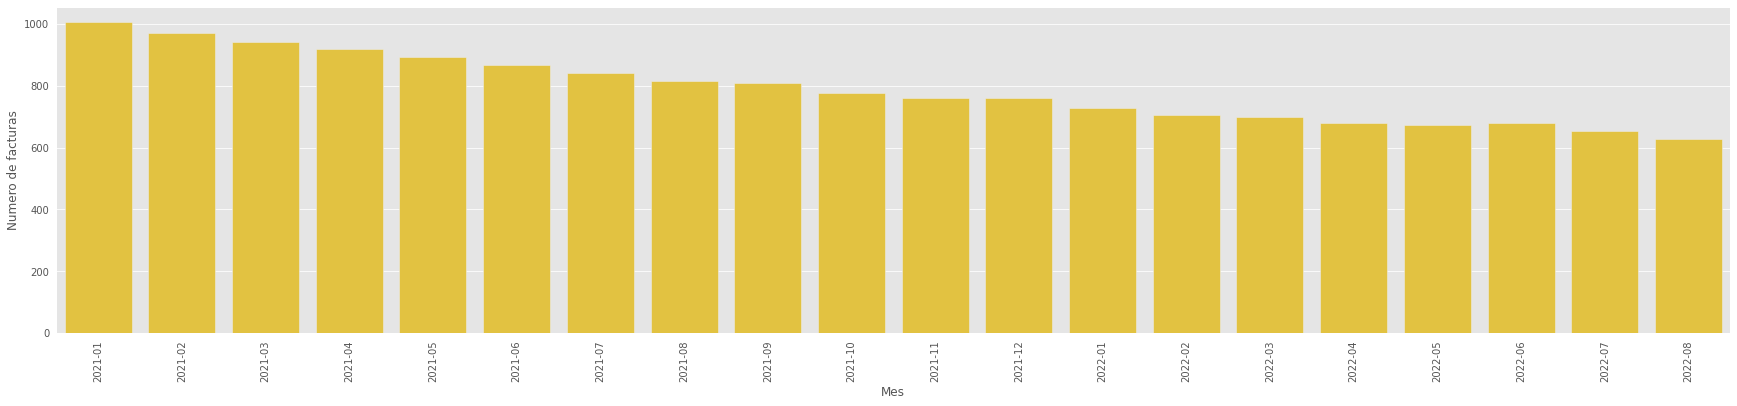

In [82]:
df_muestra['Fecha de emisión_3']=df_muestra['FEC_EMISION'].astype(str).str.slice(0,7)
numero_pagos=pd.DataFrame(df_muestra['Fecha de emisión_3'].value_counts().reset_index().sort_values('index'))

plt.figure(figsize=(30, 6))
sns.barplot(data=numero_pagos, x = 'index', y='Fecha de emisión_3', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Numero de facturas')
plt.xticks(rotation=90)
plt.show()

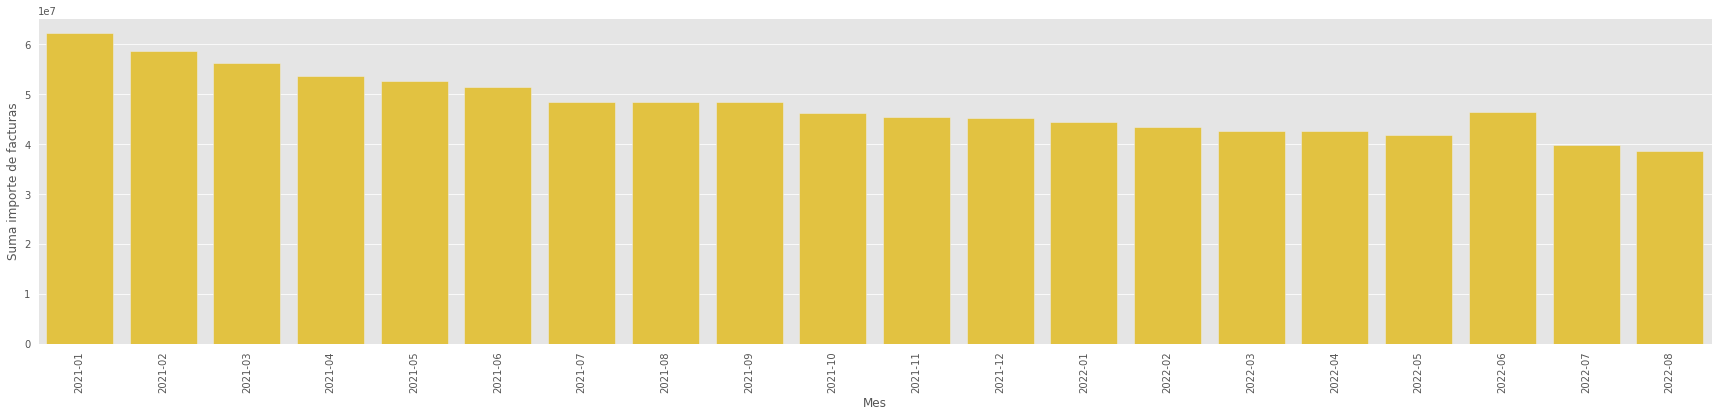

In [83]:
Importe_por_mes = df_muestra.fillna(0).groupby("Fecha de emisión_3",as_index = False)['IMP_FACTURADO'].agg(sum)

plt.figure(figsize=(30, 6))
sns.barplot(data=Importe_por_mes, x = 'Fecha de emisión_3', y='IMP_FACTURADO', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Suma importe de facturas')
plt.xticks(rotation=90)
plt.show()

## b) Evolución de las facturas impagadas y recuperadas

In [84]:
df_muestra.head(1)

,Id_cli_fact,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,TELEFONO,EMAIL_COMBINADO,FECHA_ALTA,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMP_CONSUMO,IMP_TERMINAL,PLAZOS_FINANCIACION,PLAZOS_FALTANTES,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO,Fecha de emisión_3
0,1115066610.0BEC0169773247,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,linayiselt2004@gmail.com,2020-08-10,BEC0169773247,2021-07-14,2021-07-23,33988,33988,0,nan,nan,NO,0,0,NaN,2021-07


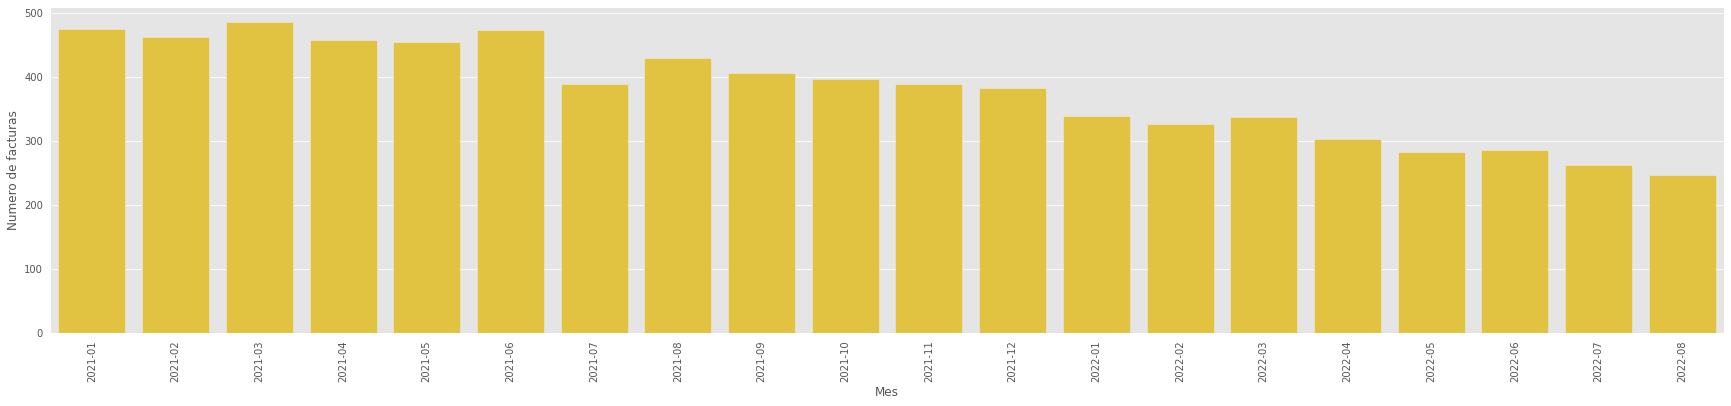

In [85]:
data_def=df_muestra[df_muestra['IMPAGADO']=='SI']
numero_impagos=pd.DataFrame(data_def['Fecha de emisión_3'].value_counts().reset_index().sort_values('index'))

plt.figure(figsize=(30, 6))
sns.barplot(data=numero_impagos, x = 'index', y='Fecha de emisión_3', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Numero de facturas')
plt.xticks(rotation=90)
plt.show()

## c) Evolucion mensual de los importes impagados y recuperado

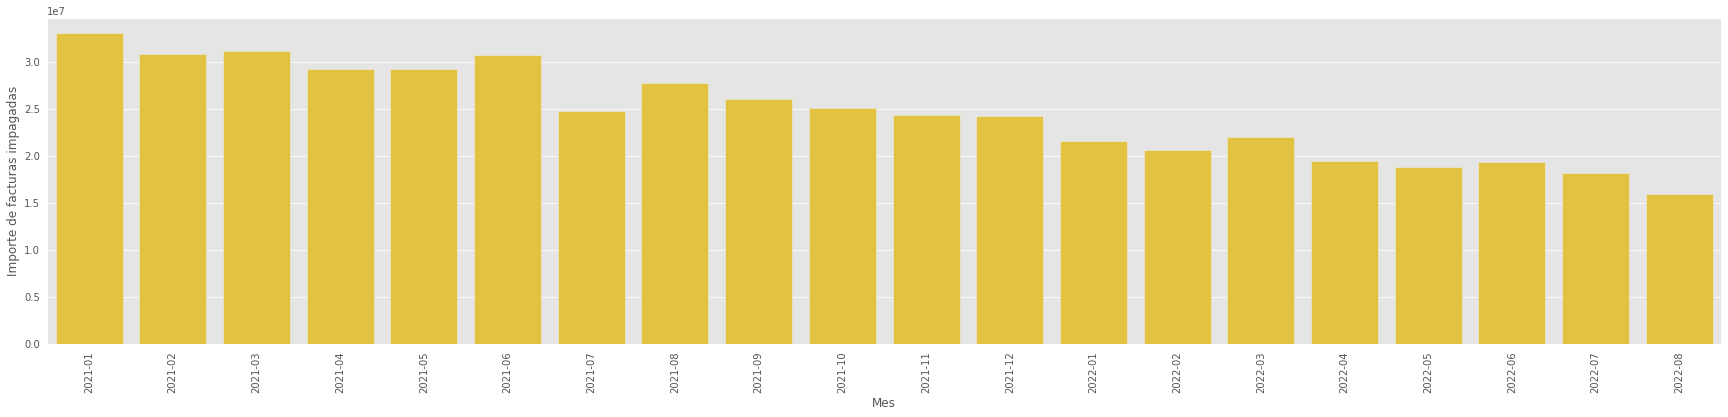

In [86]:
Importe_por_mes = data_def.fillna(0).groupby("Fecha de emisión_3",as_index = False)['IMPORTE_IMPAGADO'].agg(sum)

plt.figure(figsize=(30, 6))
sns.barplot(data=Importe_por_mes, x = 'Fecha de emisión_3', y='IMPORTE_IMPAGADO', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Importe de facturas impagadas')
plt.xticks(rotation=90)
plt.show()

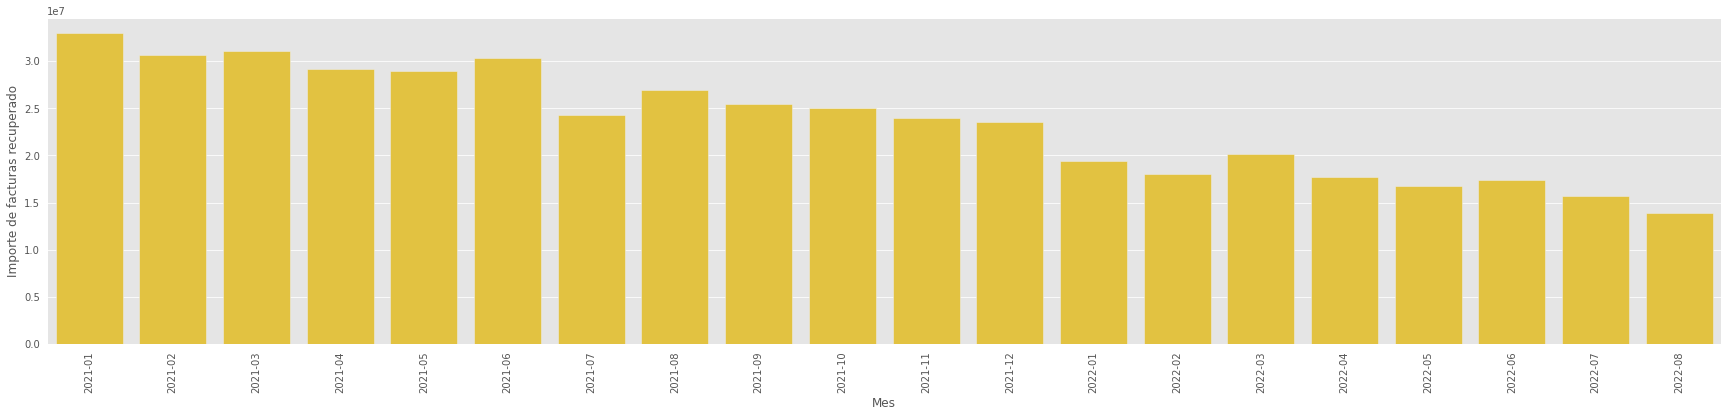

In [87]:
Importe_por_mes_2 = data_def.fillna(0).groupby("Fecha de emisión_3",as_index = False)['IMPORTE_RECUPERADO'].agg(sum)

plt.figure(figsize=(30, 6))
sns.barplot(data=Importe_por_mes_2, x = 'Fecha de emisión_3', y='IMPORTE_RECUPERADO', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Importe de facturas recuperado')
plt.xticks(rotation=90)
plt.show()

In [95]:
df_muestra.drop(columns=['Fecha de emisión_3'], inplace=True)

# 7. Importes Negativos

In [88]:
df_muestra.head(1)

,Id_cli_fact,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,TELEFONO,EMAIL_COMBINADO,FECHA_ALTA,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMP_CONSUMO,IMP_TERMINAL,PLAZOS_FINANCIACION,PLAZOS_FALTANTES,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO,Fecha de emisión_3
0,1115066610.0BEC0169773247,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,linayiselt2004@gmail.com,2020-08-10,BEC0169773247,2021-07-14,2021-07-23,33988,33988,0,nan,nan,NO,0,0,NaN,2021-07


In [179]:
print('Importes de facturas negativas: {}'.format(df_muestra[df_muestra['IMP_FACTURADO']<0].shape[0]))
print('Importes de impagados negativos: {}'.format(df_muestra[df_muestra['IMPORTE_IMPAGADO']<0].shape[0]))
print('Importes recuperados negativos: {}'.format(df_muestra[df_muestra['IMPORTE_RECUPERADO']<0].shape[0]))

Importes de facturas negativas: 218
Importes de impagados negativos: 0
Importes recuperados negativos: 22


# 10. TOTALES

In [93]:
print('Importe de la factura total: {}'.format(df_muestra['IMP_FACTURADO'].sum()))
print('Importe impagado total: {}'.format(df_muestra['IMPORTE_IMPAGADO'].sum()))
print('Importe recuperado total: {}'.format(df_muestra['IMPORTE_RECUPERADO'].sum()))
print('Porcentaje de importe impagado: {}'.format(100*df_muestra['IMPORTE_IMPAGADO'].sum()/df_muestra['IMP_FACTURADO'].sum()))
print('Porcentaje de importe recuperado: {}'.format(100*df_muestra['IMPORTE_RECUPERADO'].sum()/df_muestra['IMPORTE_IMPAGADO'].sum()))
print('Porcentaje facturas impagadas: {}'.format(100*(df_muestra[df_muestra['IMPAGADO']=='SI'].shape[0])/(df_muestra.shape[0])))
print('LGD: {}'.format(100*(1-(df_muestra['IMPORTE_RECUPERADO'].sum())/(df_muestra['IMPORTE_IMPAGADO'].sum()))))

Importe de la factura total: 957260256
Importe impagado total: 492600524
Importe recuperado total: 471276603
Porcentaje de importe impagado: 51.45941460667934
Porcentaje de importe recuperado: 95.67115340705566
Porcentaje facturas impagadas: 47.95673076923077
LGD: 4.3288465929443465


# PUNTO 13. Horizonte Temporal

In [96]:
df_muestra.head(1)

,Id_cli_fact,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,TELEFONO,EMAIL_COMBINADO,FECHA_ALTA,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMP_CONSUMO,IMP_TERMINAL,PLAZOS_FINANCIACION,PLAZOS_FALTANTES,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO
0,1115066610.0BEC0169773247,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,linayiselt2004@gmail.com,2020-08-10,BEC0169773247,2021-07-14,2021-07-23,33988,33988,0,nan,nan,NO,0,0,NaN


El horizonte temporal es desde enero de 2021 hasta diciembre de 2022, como quitamos los ultimos 4 meses, vamos a considerar unicamente hasta agosto de 2022 (incluido)

# PUNTO 14. DIAS DE ATRASO Y TARGET

In [124]:
def cambiar_fec_recu(Fecha):
    try:
        return datetime.strptime(Fecha, '%Y-%m-%d')
    except:
        if Fecha==Fecha:
            print(Fecha)
        return datetime.strptime('2022-12-28', '%Y-%m-%d')

In [125]:
df_muestra.reset_index(inplace=True)

In [126]:
df_muestra['FEC_VENCIMIENTO_2']=''
for i in range(0,df_muestra.shape[0]):
    df_muestra['FEC_VENCIMIENTO_2'][i]=datetime.strptime(df_muestra['FEC_VENCIMIENTO'][i], '%Y-%m-%d')

In [127]:
df_muestra['FECHA_RECUPERADO_Auxiliar']=df_muestra['FECHA_RECUPERADO'].apply(cambiar_fec_recu)

In [128]:
df_muestra['FECHA_RECUPERADO_Auxiliar'].iloc[0]

Timestamp('2022-12-28 00:00:00')

In [129]:
df_muestra['FEC_VENCIMIENTO_2'].iloc[0]

datetime.datetime(2021, 7, 23, 0, 0)

In [130]:
df_muestra['dias_en_default']=np.where((df_muestra['IMPAGADO']=='SI'), 
                                     df_muestra['FECHA_RECUPERADO_Auxiliar'] - df_muestra['FEC_VENCIMIENTO_2'] , 
                                     df_muestra['FECHA_RECUPERADO_Auxiliar']-df_muestra['FECHA_RECUPERADO_Auxiliar'])

In [152]:
df_muestra.drop(columns=['FEC_VENCIMIENTO_2','FECHA_RECUPERADO_Auxiliar'], inplace=True)

In [131]:
df_muestra.head()

,level_0,index,Id_cli_fact,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,TELEFONO,EMAIL_COMBINADO,FECHA_ALTA,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMP_CONSUMO,IMP_TERMINAL,PLAZOS_FINANCIACION,PLAZOS_FALTANTES,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO,FEC_VENCIMIENTO_2,FECHA_RECUPERADO_Auxiliar,dias_en_default,Default_90_dias
0,0,0,1115066610.0BEC0169773247,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,linayiselt2004@gmail.com,2020-08-10,BEC0169773247,2021-07-14,2021-07-23,33988,33988,0,nan,nan,NO,0,0,NaN,2021-07-23 00:00:00,2022-12-28,0 days,0
1,1,1,1115066610.0BEC0218361857,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,linayiselt2004@gmail.com,2020-08-10,BEC0218361857,2022-04-11,2022-04-21,35102,35102,0,nan,nan,SI,35102,35102,2022-04-23,2022-04-21 00:00:00,2022-04-23,2 days,0
2,2,2,72337228.0BEC0170127389,ORNEY JOSE PUELLO ESPAÑA,29-35,72337228.0000,CLL 7C #11 100,BOGOTA DC,NaN,nan,acuaries1625@gmail.com,2020-08-10,BEC0170127389,2021-07-17,2021-07-24,137027,87031,49996,12.0000,8.0000,SI,137027,137027,2021-07-30,2021-07-24 00:00:00,2021-07-30,6 days,0
3,3,3,9088206.0BEC0173888702,CRISTOBAL BARRIOS PITALUA,56-65,9088206.0000,CL 35 KR 49-19,CARTAGENA,COSTA,nan,karinabarrios80@outlook.es,2020-09-21,BEC0173888702,2021-08-04,2021-08-13,56713,56713,0,nan,nan,NO,0,0,NaN,2021-08-13 00:00:00,2022-12-28,0 days,0
4,4,4,1063487651.0BEC0219153140,OSMELIA RANGEL PEREZ,29-35,1063487651.0000,MZ S CASA 9 ARKALA II,IBAGUE,ORIENTE,nan,osmeliarangelperez@gmail.com,2020-10-07,BEC0219153140,2022-04-19,2022-04-26,1393,1393,0,nan,nan,NO,0,0,NaN,2022-04-26 00:00:00,2022-12-28,0 days,0


In [132]:
df_muestra['dias_en_default'] = pd.to_numeric(df_muestra['dias_en_default'].dropna().astype(str).str.split(' ').apply(lambda x: x[0]))

In [133]:
df_muestra['Default_90_dias'] = np.where(df_muestra['dias_en_default']>90, 1, 0)
print('Numero de facturas con mas de 90 dias de atraso: {}'.format(df_muestra['Default_90_dias'].sum()))
print('Porcentaje de facturas con mas de 90 dias de atraso: {}'.format(100*(df_muestra['Default_90_dias'].sum()/df_muestra['Default_90_dias'].shape[0])))
print('Porcentaje de dinero impagado mas de 90 dias de atraso: {}'.format(100*(df_muestra[df_muestra['Default_90_dias']>0]['IMPORTE_IMPAGADO'].sum()/df_muestra['IMP_FACTURADO'].sum())))

Numero de facturas con mas de 90 dias de atraso: 195
Porcentaje de facturas con mas de 90 dias de atraso: 1.2335526315789473
Porcentaje de dinero impagado mas de 90 dias de atraso: 1.1110576181698282


In [211]:
100*df_muestra[df_muestra['IMPAGADO']=='SI']['NUM_IDENT'].nunique()/df_muestra['NUM_IDENT'].nunique()

81.34403209628887

In [214]:
100*df_muestra[df_muestra['IMPAGADO']=='SI'].shape[0]/df_muestra.shape[0]

47.95673076923077

In [134]:
df_muestra[df_muestra['Default_90_dias']==1]['NUM_IDENT'].nunique()

69

In [143]:
print('La PD en terminos de numero de clientes es de: {}%'.format(100*df_muestra[df_muestra['Default_90_dias']==1]['NUM_IDENT'].nunique()/df_muestra['NUM_IDENT'].nunique()))

La PD en terminos de numero de clientes es de: 6.920762286860581%


In [154]:
df_muestra['Default_120_dias'] = np.where(df_muestra['dias_en_default']>120, 1, 0)
print('Numero de facturas con mas de 120 dias de atraso: {}'.format(df_muestra['Default_120_dias'].sum()))
print('Porcentaje de facturas con mas de 120 dias de atraso: {}'.format(100*(df_muestra['Default_120_dias'].sum()/df_muestra['Default_120_dias'].shape[0])))
print('Porcentaje de dinero impagado mas de 120 dias de atraso: {}'.format(100*(df_muestra[df_muestra['Default_120_dias']>0]['IMPORTE_IMPAGADO'].sum()/df_muestra['IMP_FACTURADO'].sum())))

Numero de facturas con mas de 120 dias de atraso: 139
Porcentaje de facturas con mas de 120 dias de atraso: 0.8793016194331984
Porcentaje de dinero impagado mas de 120 dias de atraso: 0.7236649549148314


In [155]:
df_muestra[df_muestra['Default_120_dias']==1]['NUM_IDENT'].nunique()

44

In [156]:
print('La PD en terminos de numero de clientes es de: {}%'.format(100*df_muestra[df_muestra['Default_120_dias']==1]['NUM_IDENT'].nunique()/df_muestra['NUM_IDENT'].nunique()))

La PD en terminos de numero de clientes es de: 4.413239719157472%


# TOTALES PARA DEFAULT 90 DIAS

In [202]:
df_muestra[df_muestra['Default_90_dias']==1].shape[0]

195

In [206]:
100*df_muestra[df_muestra['Default_90_dias']==1]['NUM_IDENT'].nunique()/df_muestra['NUM_IDENT'].nunique()

6.920762286860581

In [148]:
print('Importe impagado total: {}'.format(df_muestra[df_muestra['Default_90_dias']==1]['IMPORTE_IMPAGADO'].sum()))
print('Importe recuperado total: {}'.format(df_muestra[df_muestra['Default_90_dias']==1]['IMPORTE_RECUPERADO'].sum()))
print('Porcentaje de importe impagado: {}'.format(100*df_muestra[df_muestra['Default_90_dias']==1]['IMPORTE_IMPAGADO'].sum()/df_muestra['IMP_FACTURADO'].sum()))
print('Porcentaje de importe recuperado: {}'.format(100*df_muestra[df_muestra['Default_90_dias']==1]['IMPORTE_RECUPERADO'].sum()/df_muestra[df_muestra['Default_90_dias']==1]['IMPORTE_IMPAGADO'].sum()))
print('Porcentaje facturas impagadas: {}'.format(100*(df_muestra[df_muestra['Default_90_dias']==1].shape[0])/(df_muestra.shape[0])))
print('LGD: {}'.format(100*(1-(df_muestra[df_muestra['Default_90_dias']==1]['IMPORTE_RECUPERADO'].sum())/(df_muestra[df_muestra['Default_90_dias']==1]['IMPORTE_IMPAGADO'].sum()))))

Importe impagado total: 10635713
Importe recuperado total: 7697216
Porcentaje de importe impagado: 1.1110576181698282
Porcentaje de importe recuperado: 72.37141506168886
Porcentaje facturas impagadas: 1.2335526315789473
LGD: 27.62858493831114


In [153]:
df_muestra.head()

,level_0,index,Id_cli_fact,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,TELEFONO,EMAIL_COMBINADO,FECHA_ALTA,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO,dias_en_default,Default_90_dias
0,0,0,1115066610.0BEC0169773247,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,linayiselt2004@gmail.com,2020-08-10,BEC0169773247,2021-07-14,2021-07-23,33988,NO,0,0,NaN,0,0
1,1,1,1115066610.0BEC0218361857,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,linayiselt2004@gmail.com,2020-08-10,BEC0218361857,2022-04-11,2022-04-21,35102,SI,35102,35102,2022-04-23,2,0
2,2,2,72337228.0BEC0170127389,ORNEY JOSE PUELLO ESPAÑA,29-35,72337228.0000,CLL 7C #11 100,BOGOTA DC,NaN,nan,acuaries1625@gmail.com,2020-08-10,BEC0170127389,2021-07-17,2021-07-24,137027,SI,137027,137027,2021-07-30,6,0
3,3,3,9088206.0BEC0173888702,CRISTOBAL BARRIOS PITALUA,56-65,9088206.0000,CL 35 KR 49-19,CARTAGENA,COSTA,nan,karinabarrios80@outlook.es,2020-09-21,BEC0173888702,2021-08-04,2021-08-13,56713,NO,0,0,NaN,0,0
4,4,4,1063487651.0BEC0219153140,OSMELIA RANGEL PEREZ,29-35,1063487651.0000,MZ S CASA 9 ARKALA II,IBAGUE,ORIENTE,nan,osmeliarangelperez@gmail.com,2020-10-07,BEC0219153140,2022-04-19,2022-04-26,1393,NO,0,0,NaN,0,0


# TOTALES PARA DEFAULT 120 DIAS

In [158]:
print('Importe impagado total: {}'.format(df_muestra[df_muestra['Default_120_dias']==1]['IMPORTE_IMPAGADO'].sum()))
print('Importe recuperado total: {}'.format(df_muestra[df_muestra['Default_120_dias']==1]['IMPORTE_RECUPERADO'].sum()))
print('Porcentaje de importe impagado: {}'.format(100*df_muestra[df_muestra['Default_120_dias']==1]['IMPORTE_IMPAGADO'].sum()/df_muestra['IMP_FACTURADO'].sum()))
print('Porcentaje de importe recuperado: {}'.format(100*df_muestra[df_muestra['Default_120_dias']==1]['IMPORTE_RECUPERADO'].sum()/df_muestra[df_muestra['Default_120_dias']==1]['IMPORTE_IMPAGADO'].sum()))
print('Porcentaje facturas impagadas: {}'.format(100*(df_muestra[df_muestra['Default_120_dias']==1].shape[0])/(df_muestra.shape[0])))
print('LGD: {}'.format(100*(1-(df_muestra[df_muestra['Default_120_dias']==1]['IMPORTE_RECUPERADO'].sum())/(df_muestra[df_muestra['Default_120_dias']==1]['IMPORTE_IMPAGADO'].sum()))))

Importe impagado total: 6927357
Importe recuperado total: 4297938
Porcentaje de importe impagado: 0.7236649549148314
Porcentaje de importe recuperado: 62.042969634739485
Porcentaje facturas impagadas: 0.8793016194331984
LGD: 37.957030365260515


In [215]:
100*df_muestra[df_muestra['Default_120_dias']==1]['NUM_IDENT'].nunique()/df_muestra['NUM_IDENT'].nunique()

4.413239719157472

In [216]:
df_muestra[df_muestra['Default_120_dias']==1]['NUM_IDENT'].nunique()

44

In [220]:
df_muestra[df_muestra['Default_120_dias']==1].shape[0]

139

In [219]:
100*df_muestra[df_muestra['Default_120_dias']==1].shape[0]/df_muestra.shape[0]

0.8793016194331984

In [159]:
df_muestra.head()

,level_0,index,Id_cli_fact,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,TELEFONO,EMAIL_COMBINADO,FECHA_ALTA,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO,dias_en_default,Default_90_dias,Default_120_dias
0,0,0,1115066610.0BEC0169773247,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,linayiselt2004@gmail.com,2020-08-10,BEC0169773247,2021-07-14,2021-07-23,33988,NO,0,0,NaN,0,0,0
1,1,1,1115066610.0BEC0218361857,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,linayiselt2004@gmail.com,2020-08-10,BEC0218361857,2022-04-11,2022-04-21,35102,SI,35102,35102,2022-04-23,2,0,0
2,2,2,72337228.0BEC0170127389,ORNEY JOSE PUELLO ESPAÑA,29-35,72337228.0000,CLL 7C #11 100,BOGOTA DC,NaN,nan,acuaries1625@gmail.com,2020-08-10,BEC0170127389,2021-07-17,2021-07-24,137027,SI,137027,137027,2021-07-30,6,0,0
3,3,3,9088206.0BEC0173888702,CRISTOBAL BARRIOS PITALUA,56-65,9088206.0000,CL 35 KR 49-19,CARTAGENA,COSTA,nan,karinabarrios80@outlook.es,2020-09-21,BEC0173888702,2021-08-04,2021-08-13,56713,NO,0,0,NaN,0,0,0
4,4,4,1063487651.0BEC0219153140,OSMELIA RANGEL PEREZ,29-35,1063487651.0000,MZ S CASA 9 ARKALA II,IBAGUE,ORIENTE,nan,osmeliarangelperez@gmail.com,2020-10-07,BEC0219153140,2022-04-19,2022-04-26,1393,NO,0,0,NaN,0,0,0


# TENURE

In [181]:
df_muestra['Fecha_Actual'] = pd.to_datetime('2022-12-28')

In [183]:
df_muestra['Tenure'] = df_muestra['Fecha_Actual'] - pd.to_datetime(df_muestra['FECHA_ALTA'])

In [188]:
df_muestra['Tenure'] = pd.to_numeric(df_muestra['Tenure'].astype(str).str.split(' ').apply(lambda x: x[0]), errors='coerce')

In [197]:
df_muestra['Fecha_Actual_agosto'] = pd.to_datetime('2022-08-31')
df_muestra['Tenure_agosto'] = df_muestra['Fecha_Actual_agosto'] - pd.to_datetime(df_muestra['FECHA_ALTA'])
df_muestra['Tenure_agosto'] = pd.to_numeric(df_muestra['Tenure_agosto'].astype(str).str.split(' ').apply(lambda x: x[0]), errors='coerce')

In [198]:
df_muestra['Fecha_Actual_abril'] = pd.to_datetime('2022-04-30')
df_muestra['Tenure_abril'] = df_muestra['Fecha_Actual_abril'] - pd.to_datetime(df_muestra['FECHA_ALTA'])
df_muestra['Tenure_abril'] = pd.to_numeric(df_muestra['Tenure_abril'].astype(str).str.split(' ').apply(lambda x: x[0]), errors='coerce')

In [199]:
df_muestra.head()

,level_0,index,Id_cli_fact,NOMBRE_CLIENTE,EDAD_GRUPO,NUM_IDENT,DIRECCION,CIUDAD,REGION,TELEFONO,EMAIL_COMBINADO,FECHA_ALTA,NUM_FACTURA,FEC_EMISION,FEC_VENCIMIENTO,IMP_FACTURADO,IMPAGADO,IMPORTE_IMPAGADO,IMPORTE_RECUPERADO,FECHA_RECUPERADO,dias_en_default,Default_90_dias,Default_120_dias,Fecha_Actual,Tenure,Fecha_Actual_agosto,Tenure_agosto,Fecha_Actual_abril,Tenure_abril
0,0,0,1115066610.0BEC0169773247,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,linayiselt2004@gmail.com,2020-08-10,BEC0169773247,2021-07-14,2021-07-23,33988,NO,0,0,NaN,0,0,0,2022-12-28,870.0000,2022-08-31,751.0000,2022-04-30,628.0000
1,1,1,1115066610.0BEC0218361857,LINA YISELT ESCOBEDO VALENCIA,29-35,1115066610.0000,KR KR 16 CL 30 50,GUADALAJARA DE BUGA,SUROCCIDENTE,nan,linayiselt2004@gmail.com,2020-08-10,BEC0218361857,2022-04-11,2022-04-21,35102,SI,35102,35102,2022-04-23,2,0,0,2022-12-28,870.0000,2022-08-31,751.0000,2022-04-30,628.0000
2,2,2,72337228.0BEC0170127389,ORNEY JOSE PUELLO ESPAÑA,29-35,72337228.0000,CLL 7C #11 100,BOGOTA DC,NaN,nan,acuaries1625@gmail.com,2020-08-10,BEC0170127389,2021-07-17,2021-07-24,137027,SI,137027,137027,2021-07-30,6,0,0,2022-12-28,870.0000,2022-08-31,751.0000,2022-04-30,628.0000
3,3,3,9088206.0BEC0173888702,CRISTOBAL BARRIOS PITALUA,56-65,9088206.0000,CL 35 KR 49-19,CARTAGENA,COSTA,nan,karinabarrios80@outlook.es,2020-09-21,BEC0173888702,2021-08-04,2021-08-13,56713,NO,0,0,NaN,0,0,0,2022-12-28,828.0000,2022-08-31,709.0000,2022-04-30,586.0000
4,4,4,1063487651.0BEC0219153140,OSMELIA RANGEL PEREZ,29-35,1063487651.0000,MZ S CASA 9 ARKALA II,IBAGUE,ORIENTE,nan,osmeliarangelperez@gmail.com,2020-10-07,BEC0219153140,2022-04-19,2022-04-26,1393,NO,0,0,NaN,0,0,0,2022-12-28,812.0000,2022-08-31,693.0000,2022-04-30,570.0000


## Distribucion del Target

In [195]:
print(df_muestra['Tenure'].quantile(0.05))
print(df_muestra['Tenure'].quantile(0.1))
print(df_muestra['Tenure'].quantile(0.9))
print(df_muestra['Tenure'].quantile(0.95))
df_muestra['Tenure'].describe()

779.0
835.0
3927.0
4797.0


count   15798.0000
mean     2022.4463
std      1453.7523
min       713.0000
25%      1030.0000
50%      1485.0000
75%      2549.0000
max     12088.0000
Name: Tenure, dtype: float64

In [200]:
print(df_muestra['Tenure_agosto'].quantile(0.05))
print(df_muestra['Tenure_agosto'].quantile(0.1))
print(df_muestra['Tenure_agosto'].quantile(0.9))
print(df_muestra['Tenure_agosto'].quantile(0.95))
df_muestra['Tenure_agosto'].describe()

660.0
716.0
3808.0
4678.0


count   15798.0000
mean     1903.4463
std      1453.7523
min       594.0000
25%       911.0000
50%      1366.0000
75%      2430.0000
max     11969.0000
Name: Tenure_agosto, dtype: float64

In [201]:
print(df_muestra['Tenure_abril'].quantile(0.05))
print(df_muestra['Tenure_abril'].quantile(0.1))
print(df_muestra['Tenure_abril'].quantile(0.9))
print(df_muestra['Tenure_abril'].quantile(0.95))
df_muestra['Tenure_abril'].describe()

537.0
593.0
3685.0
4555.0


count   15798.0000
mean     1780.4463
std      1453.7523
min       471.0000
25%       788.0000
50%      1243.0000
75%      2307.0000
max     11846.0000
Name: Tenure_abril, dtype: float64

Vemos como el Tenure es en todos los casos mayor a 6 meses. Es una cartera muy antigua segun como estan informadas las fechas de Alta y la de baja (no existe y por tanto la ultima fecha disponible)

# PREPARO DATASET PARA ENRIQUECER

In [361]:
data_new_3=pd.read_csv('gs://bucket_nb/progress/XXXXX-fenie/Fenie_post_QA0.csv', sep=';', index_col=False)

In [99]:
data_new_3.shape

(5889522, 27)

In [46]:
data_new_3.sort_values(by=['NIF/DNI','CUPS','Fecha_emisión'], ascending=False, inplace=True)

In [47]:
data_new_por_cliente=data_new_3[['Nombre y apellidos ','NIF/DNI','Dirección completa ','Código postal','Email ','Teléfono ','Default_120_dias_pers','Default_90_dias_pers', 'CUPS']].copy()
data_new_por_cliente.drop_duplicates(subset='NIF/DNI', keep='first',inplace=True)

In [197]:
#data_new_por_cliente_sample=data_new_por_cliente.sample(10)

In [198]:
#data_new_por_cliente_sample.to_csv('gs://bucket_nb/progress/XXXXX-fenie/data_to_enrich_Fenie_sample.csv', sep=';', index=False)

In [218]:
#data_new_por_cliente.to_csv('gs://bucket_nb/progress/XXXXX-fenie/data_to_enrich_Fenie.csv', sep=';', index=False)

### Como la poblacion de clientes de Fenie es muy grande voy a buscar una muestra representativa

In [371]:
print(data_new_por_cliente.shape)
data_new_por_cliente.head()

(318034, 10)


,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,Default_120_dias_pers,Default_90_dias_pers,CUPS,pk
4359238,Michael Douglas Sidebottom,y5326311P,"Córdoba 0026, A, 03178 Urbanización Atalaya Park (ALACANT/ALICANTE)",3178,michaeldsidebottom@gmail.com,NaN,0,0,ES0021000010362172FW,1
4477627,Oliver Gerd Erpeldinger,y3936446x,"Polígono 0013, 466, 07620 Llucmajor (BALEARS)",7620,oliver.erpeldinger@gmx.de,NaN,0,0,ES0031500548639001PK0F,2
2871398,Catherine Mary Young,y3924532x,"MIGJORN 21, 6-C, 17130 Escala, L' (GIRONA)",17130,albercanfe@hotmail.com,34972772740.0000,1,1,ES0031406045476007HY0F,3
4054636,Alessandro Bin,y3449610s,"Los Molinos 0018, Bjo, 38670 Adeje (S.C. TENERIFE)",38670,heliosproperties.tenerife@gmail.com,34674580927,0,0,ES0031607607069002RH,4
4416725,Ekaterina Yurkova,y3097833t,"Avda Ciutat de Requena 0004, 2, 1, D, 03570 Villajoyosa-La Vila Joiosa (ALACANT/ALICANTE)",3570,talleresguillermo@gmail.com,NaN,0,0,ES0021000019534106NL,5


In [48]:
data_new_por_cliente_sample_final=pd.read_csv('gs://bucket_nb/progress/XXXXX-fenie/data_to_enrich_Fenie_sample_final_100K.csv', sep=';',index_col=False)

In [220]:
#data_new_por_cliente_sample_final=data_new_por_cliente.sample(100000)

In [49]:
data_new_por_cliente.head(2)

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,Default_120_dias_pers,Default_90_dias_pers,CUPS
1666348,Michael Douglas Sidebottom,y5326311P,"Córdoba 0026, A, 03178 Urbanización Atalaya Park (ALACANT/ALICANTE)",3178,michaeldsidebottom@gmail.com,NaN,0,0,ES0021000010362172FW
1715692,Oliver Gerd Erpeldinger,y3936446x,"Polígono 0013, 466, 07620 Llucmajor (BALEARS)",7620,oliver.erpeldinger@gmx.de,NaN,0,0,ES0031500548639001PK0F


In [56]:
data_new_por_cliente.shape

(307142, 9)

In [50]:
data_new_por_cliente_sample_final.head(2)

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,pk
0,Trinidad Moreno Romero,80126033J,"CAMILO JOSE CELA 9, Loc. E, 14520 FERNAN-NUÑEZ (CORDOBA)",14520,pelusomorenoromero@gmail.com,34957311298,40513
1,Adrián Hiebra Pardo,44489552P,"UR ALBATROS HILL CLUB-PLEYADES 1, 1-B, 29660 MARBELLA (MALAGA)",29660,adrian.hiebra@gmail.com,34672467211,142440


# AÑADIDO PARA COGER CUPS

In [51]:
print(data_new_por_cliente_sample_final.shape)
data_new_por_cliente_sample_final.head(2)

(100000, 7)


,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,pk
0,Trinidad Moreno Romero,80126033J,"CAMILO JOSE CELA 9, Loc. E, 14520 FERNAN-NUÑEZ (CORDOBA)",14520,pelusomorenoromero@gmail.com,34957311298,40513
1,Adrián Hiebra Pardo,44489552P,"UR ALBATROS HILL CLUB-PLEYADES 1, 1-B, 29660 MARBELLA (MALAGA)",29660,adrian.hiebra@gmail.com,34672467211,142440


In [52]:
data_new_por_cliente_sample_final_2=pd.read_csv('gs://bucket_nb/progress/XXXXX-fenie/data_to_enrich_Fenie_con_CUPS_corriegido_Target.csv', sep=';', index_col=False)

In [53]:
print(data_new_por_cliente_sample_final_2.shape)
data_new_por_cliente_sample_final_2.head(2)

(99828, 8)


,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,pk,CUPS
0,Trinidad Moreno Romero,80126033J,"CAMILO JOSE CELA 9, Loc. E, 14520 FERNAN-NUÑEZ (CORDOBA)",14520,pelusomorenoromero@gmail.com,34957311298,40513,ES0031104405513001MT0F
1,Adrián Hiebra Pardo,44489552P,"UR ALBATROS HILL CLUB-PLEYADES 1, 1-B, 29660 MARBELLA (MALAGA)",29660,adrian.hiebra@gmail.com,34672467211,142440,ES0031104589019004XC0F


In [54]:
data_new_por_cliente_sample_final_3=data_new_por_cliente_sample_final.merge(data_new_por_cliente_sample_final_2[['pk','CUPS']], how='inner', on='pk')

In [55]:
print(data_new_por_cliente_sample_final_3.shape)
data_new_por_cliente_sample_final_3.head()

(99828, 8)


,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,pk,CUPS
0,Trinidad Moreno Romero,80126033J,"CAMILO JOSE CELA 9, Loc. E, 14520 FERNAN-NUÑEZ (CORDOBA)",14520,pelusomorenoromero@gmail.com,34957311298,40513,ES0031104405513001MT0F
1,Adrián Hiebra Pardo,44489552P,"UR ALBATROS HILL CLUB-PLEYADES 1, 1-B, 29660 MARBELLA (MALAGA)",29660,adrian.hiebra@gmail.com,34672467211,142440,ES0031104589019004XC0F
2,MARY EVANGELINE VELLACOTT,X8543462C,"SAN MIGUEL 20, 38639 GOLF DEL SUR (S.C. TENERIFE)",38639,mail@vivosol.com,34922792379,24155,ES0031607339059015KS0F
3,Rocío Martín Pérez,50101002X,"Embajadores 0052, 1, A, 28012 Madrid (MADRID)",28012,rmartin69@hotmail.es,34639332002,118032,ES0021000011126585FX
4,Asunción De Celis Blanco,13871272H,"BO MIGEOS 18, BAJO, 39547 LA REVILLA (SAN VICENTE DE LA BARQUERA) (CANTABRIA)",39547,NaN,NaN,272883,ES0027700236836001DD0F


In [81]:
print(data_new_por_cliente.shape)
data_new_por_cliente.head()

(307142, 9)


,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,Default_120_dias_pers,Default_90_dias_pers,CUPS
1666348,Michael Douglas Sidebottom,y5326311P,"Córdoba 0026, A, 03178 Urbanización Atalaya Park (ALACANT/ALICANTE)",3178,michaeldsidebottom@gmail.com,NaN,0,0,ES0021000010362172FW
1715692,Oliver Gerd Erpeldinger,y3936446x,"Polígono 0013, 466, 07620 Llucmajor (BALEARS)",7620,oliver.erpeldinger@gmx.de,NaN,0,0,ES0031500548639001PK0F
2789383,Catherine Mary Young,y3924532x,"MIGJORN 21, 6-C, 17130 Escala, L' (GIRONA)",17130,albercanfe@hotmail.com,34972772740.0000,1,1,ES0031406045476007HY0F
1823658,Alessandro Bin,y3449610s,"Los Molinos 0018, Bjo, 38670 Adeje (S.C. TENERIFE)",38670,heliosproperties.tenerife@gmail.com,34674580927,0,0,ES0031607607069002RH
1728357,Ekaterina Yurkova,y3097833t,"Avda Ciutat de Requena 0004, 2, 1, D, 03570 Villajoyosa-La Vila Joiosa (ALACANT/ALICANTE)",3570,talleresguillermo@gmail.com,NaN,0,0,ES0021000019534106NL


In [82]:
data_new_por_cliente_merge_con_CUPS_12=data_new_por_cliente_sample_final_3.merge(data_new_por_cliente[['NIF/DNI','CUPS','Default_120_dias_pers','Default_90_dias_pers']], how='inner', on=['NIF/DNI','CUPS'])

In [83]:
data_new_por_cliente_merge_con_CUPS_12.shape

(96187, 10)

In [85]:
data_new_por_cliente_merge_con_CUPS_12.head(3)

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,pk,CUPS,Default_120_dias_pers,Default_90_dias_pers
0,Trinidad Moreno Romero,80126033J,"CAMILO JOSE CELA 9, Loc. E, 14520 FERNAN-NUÑEZ (CORDOBA)",14520,pelusomorenoromero@gmail.com,34957311298,40513,ES0031104405513001MT0F,0,0
1,Adrián Hiebra Pardo,44489552P,"UR ALBATROS HILL CLUB-PLEYADES 1, 1-B, 29660 MARBELLA (MALAGA)",29660,adrian.hiebra@gmail.com,34672467211,142440,ES0031104589019004XC0F,0,0
2,MARY EVANGELINE VELLACOTT,X8543462C,"SAN MIGUEL 20, 38639 GOLF DEL SUR (S.C. TENERIFE)",38639,mail@vivosol.com,34922792379,24155,ES0031607339059015KS0F,0,0


In [73]:
set(data_new_por_cliente_merge_con_CUPS_12[['NIF/DNI','CUPS']].apply(lambda x: (x[0],x[1]),axis=1))

{('X4183314M', 'ES0031104641371025JQ0F'),
 ('75220731J', 'ES0031104630162025NC0F'),
 ('31130218V', 'ES0021000002312476BF'),
 ('07261013M', 'ES0021000007840283TV'),
 ('04571226E', 'ES0032000002960636DD'),
 ('15672926J', 'ES0021000006571761RZ'),
 ('75700017W', 'ES0207000000001843JA0F'),
 ('11698142C', 'ES0021000010176662ZX'),
 ('73151159G', 'ES0031300690238011QQ0F'),
 ('80123293X', 'ES0031101357008003LX'),
 ('51698491B', 'ES0021000011560363FP0F'),
 ('74011010T', 'ES0021000001147296CF'),
 ('34849100Y', 'ES0031104521850011KC0F'),
 ('77287681E', 'ES0031405901403010RK0F'),
 ('36094136Y', 'ES0022000007714494BM1P'),
 ('13171496V', 'ES0021000002176224KF'),
 ('30501165Z', 'ES0031101369820002WC0F'),
 ('03843071R', 'ES0022000008034789EW'),
 ('52246855D', 'ES0031102237296005FL0F'),
 ('32327775X', 'ES0022000009072421XN1P'),
 ('43026196G', 'ES0031500154271001MA0F'),
 ('24376829A', 'ES0021000013617827SF'),
 ('16805823E', 'ES0031300019030018NB0F'),
 ('07403818A', 'ES0021000016494987NM'),
 ('44566801T',

In [74]:
lista_dni_dif=list(set(data_new_por_cliente_sample_final_2[['NIF/DNI','CUPS']].apply(lambda x: (x[0],x[1]),axis=1))-set(data_new_por_cliente_merge_con_CUPS_12[['NIF/DNI','CUPS']].apply(lambda x: (x[0],x[1]),axis=1)))

In [75]:
lista_dni_dif

[('26793935Q', 'ES0031104710756001WH0F'),
 ('15412262P', 'ES0031105543789001SC0F'),
 ('12759175V', 'ES0027700189899001ZY0F'),
 ('32012290Q', 'ES0031104791752001ST0F'),
 ('Y3808213W', 'ES0031408145336017DJ0F'),
 ('42990761N', 'ES0031500714365001RG0F'),
 ('32731356X', 'ES0031101348794006XA0F'),
 ('47339239H', 'ES0031102333589001SL'),
 ('43156152X', 'ES0031500251525001GK0F'),
 ('49017273H', 'ES0021000013291773FR'),
 ('14638075R', 'ES0143000000302615ST0F'),
 ('41369464P', 'ES0031500621812007ZE0F'),
 ('Y8514062M', 'ES0021000006922742NS'),
 ('52511647W', 'ES0031105493920001PB0F'),
 ('13171496V', 'ES0021000002176224KF'),
 ('41604835C', 'ES0031408213615009MD0F'),
 ('Y9814629Z', 'ES0031105442803006CX'),
 ('30815805Z', 'ES0021000001657093JD'),
 ('22510362D', 'ES0021000010984582CD'),
 ('48447658K', 'ES0021000011041761EX'),
 ('43400368N', 'ES0031405694748001CN0F'),
 ('Z0096118Y', 'ES0021000037273195HJ'),
 ('38130855Y', 'ES0359008658183001BW0F'),
 ('18097032B', 'ES0031300806474014BE0F'),
 ('1171831

In [77]:
data_prueba=data_new[data_new[['NIF/DNI','CUPS']].apply(lambda x: (x[0],x[1]),axis=1).isin(lista_dni_dif)]

In [78]:
data_prueba.head()

,Nombre y apellidos,Fecha de nacimiento,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,Otras variables de interés,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Estado civil,Bureau de crédito,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2
1456823,MAURICE JEAN ALAIN SERGENT,nan,"2,00376E+12","Avda MARINEROS, 18-B, 4º 2, 03182 Torrevieja (ALACANT/ALICANTE)",3182,#N/D,#N/D,"2,00376E+12",Electricidad,Agente,ES0021000001566148SY,2.0TD,nan,2022070417009.0000,99.0500,no,nan,nan,nan,nan,#N/D,NaN,2014-05-15,2022-07-04,2022-10-29,NaN
1512782,JOSE ANDRES PADILLA MARTIN,nan,03936478M,"POZO AYUSO 1, Bloque 1, 1 30, 45420 ALMONACID DE TOLEDO (TOLEDO)",45420,josanpadi14@gmail.com,34648649286,03936478M,Electricidad,Agente,ES0021000016346520CA,2.0TD,nan,2022070622805.0000,3.9200,si,3.9200,3.9200,nan,nan,Medio,2022-06-28,2022-06-11,2022-07-06,2023-06-10,2022-08-25
1512783,JOSE ANDRES PADILLA MARTIN,nan,03936478M,"POZO AYUSO 1, Bloque 1, 1 30, 45420 ALMONACID DE TOLEDO (TOLEDO)",45420,josanpadi14@gmail.com,34648649286,03936478M,Electricidad,Agente,ES0021000016346520CA,2.0TD,nan,2022070621971.0000,4.9000,no,nan,nan,nan,nan,Medio,2022-06-28,2022-06-11,2022-07-06,2023-06-10,NaN
1512837,JOSE ANTONIO ARMAS LOPEZ,nan,43828806Y,"HOYO DEL BARRIO 8, HOYO BARRIO, VIVIENDA 2, 38916 Valverde (S.C. TENERIFE)",38916,jaarmaslop@hotmail.com,34661834870,43828806Y,Electricidad,Agente,ES0031607452939001TD0F,2.0TD,nan,2022070637431.0000,68.7400,no,nan,nan,nan,nan,Medio Alto,NaN,2015-05-18,2022-07-06,2022-08-31,NaN
1544800,JOSE MANUEL PARRILLA SANCHEZ,nan,75413839J,"Pago La Cardosa s/n, Pg 48 Pla 145, 41620 Marchena (SEVILLA)",41620,jmparrilla@andalucia.notariado.org,34608391506,75413839J,Electricidad,Agente,ES0031105259050001QP0F,2.0TD,nan,2022070701402.0000,14.3300,no,nan,nan,nan,nan,Medio,NaN,2017-04-25,2022-07-07,2022-09-02,NaN


In [79]:
data_prueba[data_prueba['Fecha de vencimiento de factura_2']<'2022-08-30']

,Nombre y apellidos,Fecha de nacimiento,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,Otras variables de interés,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Estado civil,Bureau de crédito,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2


In [80]:
data_new_por_cliente_merge_con_CUPS_12.head(1)

,Nombre y apellidos _x,NIF/DNI,Dirección completa _x,Código postal_x,Email,Teléfono,pk,CUPS,Nombre y apellidos _y,Dirección completa _y,Código postal_y,Default_120_dias_pers,Default_90_dias_pers
0,Trinidad Moreno Romero,80126033J,"CAMILO JOSE CELA 9, Loc. E, 14520 FERNAN-NUÑEZ (CORDOBA)",14520,pelusomorenoromero@gmail.com,34957311298,40513,ES0031104405513001MT0F,Trinidad Moreno Romero,"CAMILO JOSE CELA 9, Loc. E, 14520 FERNAN-NUÑEZ (CORDOBA)",14520,0,0


In [ ]:
data_new_por_cliente_merge_con_CUPS_12.to_csv('gs://bucket_nb/progress/XXXXX-fenie/data_to_enrich_Fenie_con_CUPS_sin_4_meses.csv',sep=';', index=False)

In [49]:
100*data_new_por_cliente_merge_con_CUPS['Default_120_dias_pers'].mean()

1.889249509155748

In [50]:
100*data_new_por_cliente_merge_con_CUPS['Default_90_dias_pers'].mean()

2.817846696317666

In [51]:
data_new_por_cliente_merge_con_CUPS.shape

(99828, 10)

In [52]:
#data_new_por_cliente_merge_con_CUPS.to_csv('gs://bucket_nb/progress/XXXXX-fenie/data_to_enrich_Fenie_con_CUPS.csv',sep=';', index=False)

In [64]:
data_new_por_cliente_merge_con_CUPS.to_csv('gs://bucket_nb/progress/XXXXX-fenie/data_to_enrich_Fenie_con_CUPS_sin_4_meses.csv',sep=';', index=False)

#### Hasta aqui el añadido CUPS

In [142]:
lista_dni_muestra_final=data_new_por_cliente_sample_final['NIF/DNI'].to_list()

In [228]:
data_new_muestra_final = data_new[data_new['NIF/DNI'].isin(lista_dni_muestra_final)]

In [229]:
print(data_new_muestra_final.shape)
data_new_muestra_final.head()

(1850140, 30)


,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2,Fecha de emisión_3,Fecha_Rec_3,dias_en_default,Default_120_dias,Fecha Baja_3,Fecha Alta_3,tenure,pk
4777423,Michael Douglas Sidebottom,y5326311P,"Córdoba 0026, A, 03178 Urbanización Atalaya Park (ALACANT/ALICANTE)",03178,michaeldsidebottom@gmail.com,NaN,y5326311P,Electricidad,Agente,ES0021000010362172FW,2.0TD,2022113006061.0000,12.6000,no,nan,nan,NaN,NaN,2012-12-17,2022-11-30,2022-12-09,NaN,2022-11,2022-12-30,0.0000,0,2022-12-30,2012-12-17,3665,4364278
6393029,Michael Douglas Sidebottom,y5326311P,"Córdoba 0026, A, 03178 Urbanización Atalaya Park (ALACANT/ALICANTE)",3178.0,michaeldsidebottom@gmail.com,NaN,y5326311P,Electricidad,Agente,ES0021000010362172FW,2.0TD,2022103107764.0000,12.3900,no,nan,nan,NaN,NaN,2012-12-17,2022-10-31,2022-11-10,NaN,2022-10,2022-12-30,0.0000,0,2022-12-30,2012-12-17,3665,5894670
6071005,Michael Douglas Sidebottom,y5326311P,"Córdoba 0026, A, 03178 Urbanización Atalaya Park (ALACANT/ALICANTE)",03178,michaeldsidebottom@gmail.com,NaN,y5326311P,Electricidad,Agente,ES0021000010362172FW,2.0TD,2022093003747.0000,11.0600,no,nan,nan,NaN,NaN,2012-12-17,2022-09-30,2022-10-07,NaN,2022-09,2022-12-30,0.0000,0,2022-12-30,2012-12-17,3665,5591989
5769984,Michael Douglas Sidebottom,y5326311P,"Córdoba 0026, A, 03178 Urbanización Atalaya Park (ALACANT/ALICANTE)",03178,michaeldsidebottom@gmail.com,NaN,y5326311P,Electricidad,Agente,ES0021000010362172FW,2.0TD,2022090120523.0000,13.2000,no,nan,nan,NaN,NaN,2012-12-17,2022-09-01,2022-09-09,NaN,2022-09,2022-12-30,0.0000,0,2022-12-30,2012-12-17,3665,5308003
1756745,Michael Douglas Sidebottom,y5326311P,"Córdoba 0026, A, 03178 Urbanización Atalaya Park (ALACANT/ALICANTE)",03178,michaeldsidebottom@gmail.com,NaN,y5326311P,Electricidad,Agente,ES0021000010362172FW,2.0TD,2022072903492.0000,10.9000,no,nan,nan,NaN,NaN,2012-12-17,2022-07-29,2022-08-08,NaN,2022-07,2022-12-30,0.0000,0,2022-12-30,2012-12-17,3665,1677335


CARACTERISTICAS DE LA POBLACION:
- Tasa de mora en terminos de dinero = 0.32%
- Tasa de mora en terminos de numero de facturas = 0.17%
- % importe impagado = 4.14
- % importe recuperado = 3.40
- % facturas impagadas = 2.77
- LGD = 17.91

In [230]:
print('Importe de la factura total: {}'.format(data_new_muestra_final['Importe Factura'].sum()))
print('Importe impagado total: {}'.format(data_new_muestra_final['Importe impagado'].sum()))
print('Importe recuperado total: {}'.format(data_new_muestra_final['Importe recuperado'].sum()))
print('Importe impagado total: {}'.format(data_new_muestra_final['Importe Factura'].sum()-data_new_muestra_final['Importe impagado'].sum()+data_new_muestra_final['Importe recuperado'].sum()))
print('Porcentaje de importe impagado: {}'.format(100*data_new_muestra_final['Importe impagado'].sum()/data_new_muestra_final['Importe Factura'].sum()))
print('Porcentaje de importe recuperado: {}'.format(100*data_new_muestra_final['Importe recuperado'].sum()/data_new_muestra_final['Importe Factura'].sum()))
print('Porcentaje facturas impagadas: {}'.format(100*(data_new_muestra_final[data_new_muestra_final['Impago (si/no)']=='si'].shape[0])/(data_new_muestra_final.shape[0])))
print('LGD: {}'.format(100*(1-(data_new_muestra_final['Importe recuperado'].sum())/(data_new_muestra_final['Importe impagado'].sum()))))

Importe de la factura total: 118021943.65999989
Importe impagado total: 4819923.759999998
Importe recuperado total: 3961734.4400000027
Importe impagado total: 117163754.33999988
Porcentaje de importe impagado: 4.083921693312674
Porcentaje de importe recuperado: 3.3567778305812785
Porcentaje facturas impagadas: 2.7532511053217594
LGD: 17.80503930626478


In [232]:
data_new_muestra_final['Default_120_dias'] = np.where(data_new_muestra_final['dias_en_default']>120, 1, 0)
print('Numero de facturas con mas de 120 dias de atraso: {}'.format(data_new_muestra_final['Default_120_dias'].sum()))
print('Porcentaje de facturas con mas de 120 dias de atraso: {}'.format(100*(data_new_muestra_final['Default_120_dias'].sum()/data_new_muestra_final['Default_120_dias'].shape[0])))
print('Porcentaje de dinero impagado mas de 120 dias de atraso: {}'.format(100*(data_new_muestra_final[data_new_muestra_final['Default_120_dias']>0]['Importe impagado'].sum()/data_new_muestra_final['Importe Factura'].sum())))

Numero de facturas con mas de 120 dias de atraso: 3277
Porcentaje de facturas con mas de 120 dias de atraso: 0.17712173132844
Porcentaje de dinero impagado mas de 120 dias de atraso: 0.3141868694081464


### La muestra extraida es representativa de la población

# CORREGIR EL SAMPLE 100K

In [54]:
data_new_por_cliente_sample_final=pd.read_csv('gs://bucket_nb/progress/XXXXX-fenie/data_to_enrich_Fenie_sample_final_100K.csv', sep=';',index_col=False)

In [53]:
data_new_por_cliente_merge_con_CUPS=pd.read_csv('gs://bucket_nb/progress/XXXXX-fenie/data_to_enrich_Fenie_con_CUPS.csv',sep=';', index_col=False)

In [55]:
print(data_new_por_cliente_sample_final.shape)
data_new_por_cliente_sample_final.head(2)

(100000, 7)


,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,pk
0,Trinidad Moreno Romero,80126033J,"CAMILO JOSE CELA 9, Loc. E, 14520 FERNAN-NUÑEZ (CORDOBA)",14520,pelusomorenoromero@gmail.com,34957311298,40513
1,Adrián Hiebra Pardo,44489552P,"UR ALBATROS HILL CLUB-PLEYADES 1, 1-B, 29660 MARBELLA (MALAGA)",29660,adrian.hiebra@gmail.com,34672467211,142440


In [56]:
print(data_new_por_cliente_merge_con_CUPS.shape)
data_new_por_cliente_merge_con_CUPS.head(2)

(99828, 10)


,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,pk,Default_120_dias_pers,Default_90_dias_pers,CUPS
0,Trinidad Moreno Romero,80126033J,"CAMILO JOSE CELA 9, Loc. E, 14520 FERNAN-NUÑEZ (CORDOBA)",14520,pelusomorenoromero@gmail.com,34957311298,40513,0,0,ES0031104405513001MT0F
1,Adrián Hiebra Pardo,44489552P,"UR ALBATROS HILL CLUB-PLEYADES 1, 1-B, 29660 MARBELLA (MALAGA)",29660,adrian.hiebra@gmail.com,34672467211,142440,0,0,ES0031104589019004XC0F


In [57]:
data_new_por_cliente_sample_final_2=data_new_por_cliente_sample_final.merge(data_new_por_cliente_merge_con_CUPS[['CUPS','pk']], how='right', on='pk')

In [58]:
data_new_por_cliente_sample_final_2.shape

(99828, 8)

In [59]:
data_new_por_cliente_sample_final_2.to_csv('gs://bucket_nb/progress/XXXXX-fenie/data_to_enrich_Fenie_con_CUPS_corriegido_Target.csv', sep=';', index=False)

In [61]:
data_new_por_cliente_sample_final_2

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,pk,CUPS
0,Trinidad Moreno Romero,80126033J,"CAMILO JOSE CELA 9, Loc. E, 14520 FERNAN-NUÑEZ (CORDOBA)",14520,pelusomorenoromero@gmail.com,34957311298,40513,ES0031104405513001MT0F
1,Adrián Hiebra Pardo,44489552P,"UR ALBATROS HILL CLUB-PLEYADES 1, 1-B, 29660 MARBELLA (MALAGA)",29660,adrian.hiebra@gmail.com,34672467211,142440,ES0031104589019004XC0F
2,MARY EVANGELINE VELLACOTT,X8543462C,"SAN MIGUEL 20, 38639 GOLF DEL SUR (S.C. TENERIFE)",38639,mail@vivosol.com,34922792379,24155,ES0031607339059015KS0F
3,Rocío Martín Pérez,50101002X,"Embajadores 0052, 1, A, 28012 Madrid (MADRID)",28012,rmartin69@hotmail.es,34639332002,118032,ES0021000011126585FX
4,Asunción De Celis Blanco,13871272H,"BO MIGEOS 18, BAJO, 39547 LA REVILLA (SAN VICENTE DE LA BARQUERA) (CANTABRIA)",39547,NaN,NaN,272883,ES0027700236836001DD0F
...,...,...,...,...,...,...,...,...
99823,CUI YUNZHU,X4483841Z,"Avda La Alcarrachela 0044, 3, A, 41400 Écija (SEVILLA)",41400,info@gestucom.es,34635452218,30627,ES0031102790066015GN
99824,Patrick Louis C DEDOBBELEER,Y7455802K,"GINJOLER 14, 03669 LA ROMANA (ALACANT/ALICANTE)",03669,cp.balcondelsinc@gmail.com,NaN,6323,ES0021000039292689PS
99825,Fernando Parra Quevedo,03372766T,"Trinidad 0005, 40200 Cuéllar (SEGOVIA)",40200,NaN,34645554024,313146,ES0022000005285041KL1P
99826,Hortensia Rubio Díaz,75985403G,"CANAL 12, Bajo, 10391 ROSALEJO (CACERES)",10391,NaN,NaN,60782,ES0021000002484390XL


In [234]:
#data_new_por_cliente_sample_final.to_csv('gs://bucket_nb/progress/XXXXX-fenie/data_to_enrich_Fenie_sample_final_100K.csv', sep=';',index=False)